# End-to-end DSPy Workflows Guide 

# TODO: Motivation - have this problem and going to solve it with dspy and that is why we believe ti is the right solution

This guide will cover the following topics:

## Creating a Multi-stage LLM Pipeline
- Building a pipeline with an untuned model in DSPy
- Implementing batch inference (using Ray data)

## Improving the Pipeline
1. Prompt optimization
2. Fine-tuning
    - How to make an 8B model perform almost as well as a 70B model in your pipeline
3. Combining fine-tuning with prompt optimization

## Deployment
- Steps to deploy the optimized pipeline and fine-tuned model to production

## Future Work and Open Questions
- Efficient batch inference with a DSPy pipeline
- Exploring different fine-tuning methods and hyperparameter sweeps

This guide aims to provide a comprehensive overview of building, optimizing, and deploying LLM pipelines using DSPy and Anyscale.

## Set up

Node Set up:

We will be running everything on a head node that uses 4xA100-80GB GPUs. I find that L4s are usually available and suitable for this usecase. You can also use any more powerful node.

To change to use A100 GPUs, click the "1 active node" in the top right corner, then for workspace node, click the pencil icon and navigate to the A100 tab and select the 4xA100 option. If you do not see A100 in the list of GPUs, they may not be available on your cloud. Choose another kind of GPU (This notebook has been tested on X, and Y as alternatives) (TODO)

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# TODO(work): DSPy installation cell

# TODO: look at my own init file to see all the stupid extra pip installs

# !pip install -e dspy

# ignore future warnings
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [3]:
import dspy
import dsp
import os
import ujson

from dotenv import load_dotenv
# TODO: include cache in notebook
cache_dir = "/home/ray/default/dspy/cache"
if not os.path.exists(cache_dir):
    os.makedirs(cache_dir)
# I have included a .env.example with the necessary environment variables to be set
# You can also set them manually if you prefer

os.environ["DSP_CACHEDIR"] = cache_dir

load_dotenv()

dspy.settings.configure(experimental=True)

In [4]:
import litellm

litellm.set_verbose=False
litellm.suppress_debug_info=True

In [5]:
necessary_env_vars = [
    "DSP_CACHEDIR",
    "HF_TOKEN",
    "HF_HOME"
]

for var in necessary_env_vars:
    assert os.environ[var], f"{var} is not set"

In [6]:
import ray

if not ray.is_initialized():
    ray.init(runtime_env={"env_vars": os.environ, "py_modules": [dspy, dsp]})

2024-10-14 01:34:41,494	INFO worker.py:1601 -- Connecting to existing Ray cluster at address: 10.0.0.2:6379...
2024-10-14 01:34:41,503	INFO worker.py:1777 -- Connected to Ray cluster. View the dashboard at https://session-fkvdirx4bzefi53sjl55m7asad.i.anyscaleuserdata.com 
2024-10-14 01:34:41,530	INFO packaging.py:531 -- Creating a file package for local directory '/home/ray/default/dspy-1/dspy'.
2024-10-14 01:34:41,566	INFO packaging.py:359 -- Pushing file package 'gcs://_ray_pkg_f6f649a9144f3c6b.zip' (0.97MiB) to Ray cluster...
2024-10-14 01:34:41,577	INFO packaging.py:372 -- Successfully pushed file package 'gcs://_ray_pkg_f6f649a9144f3c6b.zip'.
2024-10-14 01:34:41,590	INFO packaging.py:531 -- Creating a file package for local directory '/home/ray/default/dspy-1/dsp'.
2024-10-14 01:34:41,611	INFO packaging.py:359 -- Pushing file package 'gcs://_ray_pkg_4796df1b082f04ee.zip' (0.54MiB) to Ray cluster...
2024-10-14 01:34:41,614	INFO packaging.py:372 -- Successfully pushed file package '

(autoscaler +1m0s) Tip: use `ray status` to view detailed cluster status. To disable these messages, set RAY_SCHEDULER_EVENTS=0.


We will make use of a random number generator in this notebook. We are creating a Random object here to ensure that our notebook is reproducible.

In [7]:
import random

rng = random.Random(0)

# Creating your multi-stage LLM pipeline

In [8]:
from dspy.datasets import HotPotQA
from dspy.evaluate import Evaluate
from dsp.utils.utils import deduplicate


# We are setting the experimental flag to True to make use of the fine-tuning
# features that are still in development.
dspy.settings.configure(experimental=True)

class IntentClassification(dspy.Signature):
    """As a part of a banking issue traiging system, classify the intent of a natural language query into one of the 25 labels.
    The intent should exactly match one of the following:
    ['activate_my_card', 'balance_not_updated_after_bank_transfer', 'balance_not_updated_after_cheque_or_cash_deposit', 'beneficiary_not_allowed', 'cancel_transfer', 'card_arrival', 'card_payment_fee_charged', 'card_payment_not_recognised', 'card_payment_wrong_exchange_rate', 'cash_withdrawal_charge', 'cash_withdrawal_not_recognised', 'declined_card_payment', 'declined_cash_withdrawal', 'direct_debit_payment_not_recognised', 'extra_charge_on_statement', 'pending_card_payment', 'pending_top_up', 'Refund_not_showing_up', 'request_refund', 'reverted_card_payment', 'transaction_charged_twice', 'transfer_fee_charged', 'transfer_not_received_by_recipient', 'wrong_amount_of_cash_received', 'wrong_exchange_rate_for_cash_withdrawal']
    """

    intent = dspy.InputField(desc="Intent of the query")
    label = dspy.OutputField(desc="Type of the intent; Should just be one of the 25 labels with no other text")

class IntentClassificationModule(dspy.Module):
    def __init__(self):
        self.intent_classifier = dspy.ChainOfThought(IntentClassification)
        self.valid_labels = set(["activate_my_card", "cancel_transfer", "cash_withdrawal_charge", "declined_card_payment", "declined_cash_withdrawal", "direct_debit_payment_not_recognised", "extra_charge_on_statement", "pending_card_payment", "pending_top_up", "Refund_not_showing_up", "request_refund", "reverted_card_payment", "transaction_charged_twice", "transfer_fee_charged", "transfer_not_received_by_recipient", "wrong_amount_of_cash_received", "wrong_exchange_rate_for_cash_withdrawal"])

    def forward(self, text):
        prediction = self.intent_classifier(intent=text)
        sanitized_prediction = dspy.Prediction(label=prediction.label.lower().strip().replace(" ", "_"), reasoning=prediction.reasoning)
        # if sanitized_prediction.label not in self.valid_labels:
        #     for label in self.valid_labels:
        #         if label in sanitized_prediction.label:
        #             sanitized_prediction.label = label
        #             break
        #     # this means that the prediction was not in the valid labels
        #     # Could do edit distance or something more sophisticated here
        #     # but for now just take the first
        #     sanitized_prediction.label = self.valid_labels[0]
        return sanitized_prediction

class IntentClassificationPredictModule(dspy.Module):
    def __init__(self):
        self.intent_classifier = dspy.Predict(IntentClassification)
        self.valid_labels = set(["activate_my_card", "cancel_transfer", "cash_withdrawal_charge", "declined_card_payment", "declined_cash_withdrawal", "direct_debit_payment_not_recognised", "extra_charge_on_statement", "pending_card_payment", "pending_top_up", "Refund_not_showing_up", "request_refund", "reverted_card_payment", "transaction_charged_twice", "transfer_fee_charged", "transfer_not_received_by_recipient", "wrong_amount_of_cash_received", "wrong_exchange_rate_for_cash_withdrawal"])

    def forward(self, text):
        prediction = self.intent_classifier(intent=text)
        sanitized_prediction = dspy.Prediction(label=prediction.label.lower().strip().replace(" ", "_"), reasoning=prediction.reasoning)
        # if sanitized_prediction.label not in self.valid_labels:
        #     for label in self.valid_labels:
        #         if label in sanitized_prediction.label:
        #             sanitized_prediction.label = label
        #             break
        #     # this means that the prediction was not in the valid labels
        #     # Could do edit distance or something more sophisticated here
        #     # but for now just take the first
        #     sanitized_prediction.label = self.valid_labels[0]
        return sanitized_prediction


# Let's break down the Text to SQL program

Below we load the dataset using a built in `HotPotQA` dataset class from DSPy.

We set the `train_seed` and `eval_seed` to `0` for reproducibility and the `test_size` to `0` because we do not need a test set for this tutorial.

In [9]:
# Prepare the dataset
from dspy.datasets import DataLoader

dl = DataLoader()
full_trainset = dl.from_huggingface(
    dataset_name="PolyAI/banking77", # Dataset name from Huggingface
    fields=("label", "text"), # Fields needed
    input_keys=("text",), # What our model expects to recieve to generate an output
    split="train"
)

full_testset = dl.from_huggingface(
    dataset_name="PolyAI/banking77", # Dataset name from Huggingface
    fields=("label", "text"), # Fields needed
    input_keys=("text",), # What our model expects to recieve to generate an output
    split="test"
)

# Find the 15 most common class labels
from collections import Counter

# Count occurrences of each label
label_counts = Counter(example['label'] for example in full_trainset)
print(label_counts)

# Get the 15 most common labels
top_25_labels = set([label for label, _ in label_counts.most_common(25)])

# Filter the datasets to only include examples with the top 15 labels
full_trainset_filtered = [example for example in full_trainset if example['label'] in top_25_labels]
full_testset_filtered = [example for example in full_testset if example['label'] in top_25_labels]

# Replace the original datasets with the filtered versions
full_trainset = full_trainset_filtered
full_testset = full_testset_filtered

print(f"Dataset filtered to top 25 labels. New sizes:")
print(f"Training set: {len(full_trainset)}")
print(f"Test set: {len(full_testset)}")
print(f"Top 25 labels: {', '.join(str(label) for label in top_25_labels)}")

Counter({15: 187, 28: 182, 6: 181, 75: 180, 19: 177, 63: 175, 26: 173, 64: 172, 66: 171, 5: 171, 52: 169, 16: 168, 17: 167, 34: 166, 76: 163, 51: 162, 53: 161, 20: 160, 45: 159, 0: 159, 8: 157, 7: 156, 11: 153, 25: 153, 47: 149, 48: 148, 61: 146, 59: 145, 46: 143, 13: 139, 35: 137, 73: 135, 27: 133, 54: 129, 39: 129, 9: 129, 24: 129, 67: 128, 4: 127, 36: 126, 71: 126, 2: 126, 21: 122, 30: 121, 74: 121, 29: 121, 42: 121, 31: 121, 43: 120, 33: 118, 49: 115, 58: 114, 57: 114, 70: 113, 65: 113, 32: 112, 12: 112, 14: 112, 56: 111, 1: 110, 55: 108, 38: 106, 44: 105, 69: 104, 62: 103, 68: 102, 40: 98, 60: 97, 37: 97, 50: 95, 3: 87, 22: 86, 41: 82, 18: 61, 10: 59, 72: 41, 23: 35})
Dataset filtered to top 25 labels. New sizes:
Training set: 4171
Test set: 1000
Top 25 labels: 0, 5, 6, 7, 8, 11, 15, 16, 17, 19, 20, 25, 26, 28, 34, 45, 47, 51, 52, 53, 63, 64, 66, 75, 76


In [10]:
int_to_label_dict = {
    0: "activate_my_card",
    1: "age_limit",
    2: "apple_pay_or_google_pay",
    3: "atm_support",
    4: "automatic_top_up",
    5: "balance_not_updated_after_bank_transfer",
    6: "balance_not_updated_after_cheque_or_cash_deposit",
    7: "beneficiary_not_allowed",
    8: "cancel_transfer",
    9: "card_about_to_expire",
    10: "card_acceptance",
    11: "card_arrival",
    12: "card_delivery_estimate",
    13: "card_linking",
    14: "card_not_working",
    15: "card_payment_fee_charged",
    16: "card_payment_not_recognised",
    17: "card_payment_wrong_exchange_rate",
    18: "card_swallowed",
    19: "cash_withdrawal_charge",
    20: "cash_withdrawal_not_recognised",
    21: "change_pin",
    22: "compromised_card",
    23: "contactless_not_working",
    24: "country_support",
    25: "declined_card_payment",
    26: "declined_cash_withdrawal",
    27: "declined_transfer",
    28: "direct_debit_payment_not_recognised",
    29: "disposable_card_limits",
    30: "edit_personal_details",
    31: "exchange_charge",
    32: "exchange_rate",
    33: "exchange_via_app",
    34: "extra_charge_on_statement",
    35: "failed_transfer",
    36: "fiat_currency_support",
    37: "get_disposable_virtual_card",
    38: "get_physical_card",
    39: "getting_spare_card",
    40: "getting_virtual_card",
    41: "lost_or_stolen_card",
    42: "lost_or_stolen_phone",
    43: "order_physical_card",
    44: "passcode_forgotten",
    45: "pending_card_payment",
    46: "pending_cash_withdrawal",
    47: "pending_top_up",
    48: "pending_transfer",
    49: "pin_blocked",
    50: "receiving_money",
    51: "refund_not_showing_up",
    52: "request_refund",
    53: "reverted_card_payment",
    54: "supported_cards_and_currencies",
    55: "terminate_account",
    56: "top_up_by_bank_transfer_charge",
    57: "top_up_by_card_charge",
    58: "top_up_by_cash_or_cheque",
    59: "top_up_failed",
    60: "top_up_limits",
    61: "top_up_reverted",
    62: "topping_up_by_card",
    63: "transaction_charged_twice",
    64: "transfer_fee_charged",
    65: "transfer_into_account",
    66: "transfer_not_received_by_recipient",
    67: "transfer_timing",
    68: "unable_to_verify_identity",
    69: "verify_my_identity",
    70: "verify_source_of_funds",
    71: "verify_top_up",
    72: "virtual_card_not_working",
    73: "visa_or_mastercard",
    74: "why_verify_identity",
    75: "wrong_amount_of_cash_received",
    76: "wrong_exchange_rate_for_cash_withdrawal"
}

label_to_int_dict = {v: k for k, v in int_to_label_dict.items()}

In [11]:
labels_in_use = [int_to_label_dict[label] for label in top_25_labels]

print(labels_in_use)

def convert_int_to_label(example):
    example["label"] = int_to_label_dict[example["label"]]
    return example

full_trainset = [convert_int_to_label(example) for example in full_trainset]
full_testset = [convert_int_to_label(example) for example in full_testset]

print(full_trainset[0])

['activate_my_card', 'balance_not_updated_after_bank_transfer', 'balance_not_updated_after_cheque_or_cash_deposit', 'beneficiary_not_allowed', 'cancel_transfer', 'card_arrival', 'card_payment_fee_charged', 'card_payment_not_recognised', 'card_payment_wrong_exchange_rate', 'cash_withdrawal_charge', 'cash_withdrawal_not_recognised', 'declined_card_payment', 'declined_cash_withdrawal', 'direct_debit_payment_not_recognised', 'extra_charge_on_statement', 'pending_card_payment', 'pending_top_up', 'refund_not_showing_up', 'request_refund', 'reverted_card_payment', 'transaction_charged_twice', 'transfer_fee_charged', 'transfer_not_received_by_recipient', 'wrong_amount_of_cash_received', 'wrong_exchange_rate_for_cash_withdrawal']
Example({'label': 'card_arrival', 'text': 'I am still waiting on my card?'}) (input_keys={'text'})


In [12]:
shuffled_trainset = [d for d in full_trainset]
rng.shuffle(shuffled_trainset)

# The devset shouldn't overlap
ft_trainset = shuffled_trainset[:-100]
labeled_trainset = shuffled_trainset[-100:]

testset = full_testset

Here we set up the metric and evaluator. We will be using the answer exact match metric.

The evaluator is what we will consider as our test set.

We choose `num_threads=90` because we are bottlenecked by the retrieval server, and through testing this is the maximum number of concurrent threads that can be run without causing issues for other people using the retrieval server.

In [13]:
# Prepare the metric and evaluator
from dspy.evaluate import answer_exact_match

NUM_THREADS = 50

def adjusted_exact_match(example, pred, trace=None, frac=1.0):
    example.answer = example.label
    pred.answer = pred.label
    return answer_exact_match(example, pred, trace, frac)

metric = adjusted_exact_match
common_kwargs = dict(metric=metric, num_threads=NUM_THREADS, display_progress=True, max_errors=10000)

evaluate_testset = Evaluate(devset=testset, **common_kwargs)

In [14]:
def read_jsonl(filename):
    with open(filename, "r") as f:
        return [ujson.loads(line) for line in f]

def write_jsonl(filename, data):
    with open(filename, "w") as f:
        for item in data:
            f.write(ujson.dumps(item) + "\n")

## Gathering baseline performance

run evaluate on a base pipeline

In [15]:
MAX_TOKENS = 1000
MODEL_PARAMETERS = {
  "max_tokens": MAX_TOKENS,
  "temperature": 0,
}

LOCAL_API_PARAMETERS = {
  "api_base": "http://localhost:8000/v1",
  "api_key": "fake-key-doesnt-matter"
}
vanilla_program = IntentClassificationModule()

In [16]:
# Note: Run above this to do all setup without launching any models

We will be using a local VLLM instance to run the initial benchmarks and data collection.

# Gathering training data and running the 70B Model

Now that we have a baseline for the 8B model, let's run the 70B model and compare its performance.

## Preparation

Before running the 70B model:
1. Kill the 8B server (use `Ctrl+C`) to free up memory.
2. Remember to set your HF_TOKEN and HF_HOME environment variables
3. Use the following command to start the 70B server:

   ```
   vllm serve meta-llama/Meta-Llama-3.1-70B-Instruct --port 8000 --pipeline_parallel_size 2 --enable_prefix_caching --tensor_parallel_size 2
   ```

## Parallelism Configuration

We've chosen pipeline parallelism and tensor parallelism of 2 for the 70B model based on our current setup. Here's the reasoning:

1. Model size: The 70B model has 30 parts of ~5 GB each (based on [HuggingFace documentation](https://huggingface.co/meta-llama/Meta-Llama-3.1-70B-Instruct/tree/main)).
   - Total size: 30 * 5 GB = 150 GB

2. Available VRAM:
   - Our GPUs: 80 GB VRAM x 4 = 320 GB
   - Tensor parallelism: floor(320/150) = 2
   - Pipeline parallelism: floor(num_gpus/2) = 2
   - To use all 4 GPUs efficiently:
     - Pipeline parallel size: 2
     - Tensor parallelism: 2

3. Alternative setup (8x24GB GPUs):
   - Pipeline parallel size: 1
   - Tensor parallelism: ceil(150/24) = 7

This configuration allows us to run the 70B model efficiently across our available GPU resources.

Note that I needed to add the HF_HOME var to my serve config

In [17]:
# Command for easy copying: 
# `export HF_HOME=/mnt/local_storage/huggingface`
# `vllm serve meta-llama/Meta-Llama-3.1-70B-Instruct --port 8000 --pipeline_parallel_size 2 --enable_prefix_caching --tensor_parallel_size 2`

# input("Press Enter once you have the vllm server running...")

In [18]:
llama_70b = dspy.LM(model="openai/meta-llama/Meta-Llama-3.1-70B-Instruct", **MODEL_PARAMETERS, **LOCAL_API_PARAMETERS)

In [19]:
# sanity check
test_predictor = IntentClassificationModule()
with dspy.context(lm=llama_70b):
    sample_input = testset[15]
    print(sample_input)
    print(test_predictor(**sample_input.inputs()).label)

Example({'label': 'card_arrival', 'text': 'I have been waiting longer than expected for my bank card, could you provide information on when it will arrive?'}) (input_keys={'text'})
card_arrival


In [20]:
# Lets see how the vanilla program performs on our small labeled dataset
# vanilla_program = IntentClassificationModule()
# with dspy.context(lm=llama_70b):
#     print("Evaluating the vanilla program on the devset using llama 70B...")
#     true_labeled_eval = evaluate_devset(vanilla_program)

# Optimizing the LLaMa 70B pipeline

Now we are ready to optimize the pipeline. We want to optimize the 70B pipeline in order to get the best possible data to then train our 8B model.

We will use Bootstrap Few Shot with Random Search (BFRS) to optimize the pipeline.

The essence of BFRS is to try out different configurations of few shot demonstrations per step and see which one works best on the validation set.

The cool part about BFRs is that it will automatically collect the "good" chains of thought for us and add them to the examples at each step.

Now we know how well the base pipeline performs, let's run prompt optimization on the pipeline in order to juice up the performance.

Let's go over what the hyperparameters mean:
- MAX_BOOTSTRAPPED_DEMOS: DSPy will "bootstrap" the program by collecting examples at each step that are successful and reusing those in the pipeline. This means that it will automatically collect and add chains of thought to the pipeline.
- MAX_LABELED_DEMOS: DSPy will also insert some labeled demonstrations from the training set. These would be unmodified examples from the training set that are just using the gold answer.
- NUM_CANDIDATE_PROGRAMS: This is the number of candidate programs that the optimizer will generate. The actual number of programs that are created is this plus three, as DSPy will also try a program with no examples, a program with TODO (check)
- OPTIMIZER_NUM_TRAIN and OPTIMIZER_NUM_VAL: These are the number of examples that the optimizer will use for training and validation. Note that we will be taking the "validation" set from the trainset so as the actual validation set is untouched.

In [21]:
# Optimization hyperparameters
from dspy.teleprompt.random_search import BootstrapFewShotWithRandomSearch

# Define the hyperparameters for prompt optimization
MAX_BOOTSTRAPPED_DEMOS = 3
MAX_LABELED_DEMOS = 3
NUM_CANDIDATE_PROGRAMS = 6
OPTIMIZER_NUM_TRAIN = 100
OPTIMIZER_NUM_VAL = 300

In [22]:
# Initialize the optimizer
bfrs_optimizer = BootstrapFewShotWithRandomSearch(
    metric=metric,
    max_bootstrapped_demos=MAX_BOOTSTRAPPED_DEMOS,
    max_labeled_demos=MAX_LABELED_DEMOS,
    num_candidate_programs=NUM_CANDIDATE_PROGRAMS,
    num_threads=NUM_THREADS,
    max_errors=10000
)

Going to sample between 1 and 3 traces per predictor.
Will attempt to bootstrap 6 candidate sets.


In [ ]:
# We have added this flag to save you some compute and time while running the notebook
# TODO: do prompt optimization on the 100 labeled examples
# COMPILE_PROGRAM = False
# EVAL_PROGRAM = True

# # Compile the optimizer and evaluate
# with dspy.context(lm=llama_70b):
#     vanilla_program = IntentClassificationModule()
#     if COMPILE_PROGRAM:
#         bfrs_base_program = bfrs_optimizer.compile(vanilla_program, trainset=po_trainset, valset=po_devset)
#         bfrs_base_program.save(f"b25_70b_31_bfrs_{MAX_BOOTSTRAPPED_DEMOS}_{MAX_LABELED_DEMOS}_{NUM_CANDIDATE_PROGRAMS}.json")
#     else:
#         bfrs_base_program = IntentClassificationModule()
#         bfrs_base_program.load(f"b25_70b_31_bfrs_{MAX_BOOTSTRAPPED_DEMOS}_{MAX_LABELED_DEMOS}_{NUM_CANDIDATE_PROGRAMS}.json")
#     if EVAL_PROGRAM:
#         llama_70b_bfrs_eval = evaluate_devset(bfrs_base_program)


In [ ]:
# Lets do some data analysis and cleaning
# First we will convert the data to a pandas dataframe
import pandas as pd
from dspy.teleprompt.finetune_teleprompter import bootstrap_data, convert_to_module_level_message_data

# TODO: WORKING HERE

# For realism of this scenario, we are going to delete all our labels except for our test set(which is cheating and we wouldn't have in production) and our 100 true labeled examples
def delete_labels(dataset):
    for example in dataset:
        if "label" in example:
            del example["label"]
    return dataset

ft_trainset_to_label = delete_labels(ft_trainset)
with dspy.context(lm=llama_70b):
    collected_data = bootstrap_data(vanilla_program, ft_trainset_to_label, num_threads=NUM_THREADS, max_errors=10000)
    print(collected_data[0])
    collected_data_filtered = [x for x in collected_data if x["prediction"]["label"] in labels_in_use]

    # Convert collected_data to a pandas DataFrame
    dataset = convert_to_module_level_message_data(collected_data_filtered, program=vanilla_program, exclude_demos=True)
    
print(dataset[0])
print(len(dataset))

In [ ]:
print("Data points removed:", len(collected_data) - len(collected_data_filtered))
# look at all the data that was removed to see if any can be cleaned
filtered_data = [x for x in collected_data if x["prediction"]["label"] not in labels_in_use]
bad_labels = [x["prediction"]["label"] for x in filtered_data]
print(bad_labels)

In [26]:
if False:
    with open("collected_data_filtered.jsonl", "w") as f:
        for item in collected_data_filtered:
            f.write(ujson.dumps({"example": item["example"], "prediction": item["prediction"]}) + "\n")
else:
    with open("collected_data_filtered.jsonl", "r") as f:
        collected_data_filtered = [ujson.loads(line) for line in f]


In [ ]:
# dataset_formatted = [{"messages": x} for x in dataset]

# Note: Maybe dont use devset here
dataset_filenames = {f"trainset_data_banking.jsonl": dataset}

for filename, data in dataset_filenames.items():
    # we first need to convert the data to be only the messages and to be in proper messages format
    messages_format = [{"messages": item} for item in data]
    # print(messages_format[0])

    write_jsonl(filename, messages_format)

In [ ]:
# from dspy.teleprompt.finetune_teleprompter import bootstrap_data, convert_to_module_level_message_data, bootstrap_data_for_round
# import ujson

# # This should be moved inside the finetune_teleprompter class
# def write_data(program, data, filename):
#     print("Bootstrapping and writing data to", filename)
#     correct_data = bootstrap_data(program, data, metric=metric, num_threads=NUM_THREADS, max_errors=10000)
#     correct_data_round = [x for x in correct_data if x["score"]]

#     # Convert the data to prompt completion format
#     dataset = convert_to_module_level_message_data(correct_data_round, program=program, exclude_demos=True)
    
#     dataset_formatted = [{"messages": x} for x in dataset]
#     # Format the data for finetuning using the LM
#     print("Writing dataset with length", len(dataset), "to", filename)
#     write_jsonl(filename, dataset_formatted)

# dataset_filenames = {f"ft_trainset_data_{len(ft_trainset)}.jsonl": ft_trainset, f"ft_valset_data_{len(devset)}.jsonl": devset}


# WRITE_DATA = True
# if WRITE_DATA:
#     for filename, data in dataset_filenames.items():
#         bootstrap_program = IntentClassificationModule()
#         with dspy.context(lm=llama_70b):
#             write_data(bootstrap_program, data, filename)

In [ ]:
# Let's look at an example prompt completion pair!
# with open(f"trainset_data_banking_{TRAIN_SIZE}.json", "r") as f:
#     data_example = ujson.load(f)
from pprint import pprint
data_example = read_jsonl(f"trainset_data_banking.jsonl")[0]

print("Example prompt:")
pprint(data_example["messages"][:-1])
print("<end prompt>\n"+"-"*50)
print("Example completion:")
pprint(data_example["messages"][-1])
print("<end completion>\n"+"-"*50)

# Fine-tuning

We will use LLM Forge to fine-tune the 8B model.

In order to do this, we need to format our data into the correct format (Follows OpenAI messaging format placed in a jsonl file).

We initially saved the data into a json file in prompt-completion format.

In order to prepare for finetuning, we need to do three steps:
1. Format the data into the correct format and verify that the data is valid
2. Upload the data to GCP
3. Generate the compute configuration file

After the compute configuration file is generated, we can submit the job to LLM Forge, using either the command line or using the anyscale jobs sdk.
TODO: Add the anyscale jobs sdk submit method

In [ ]:
from dsp.modules.lm import TrainingMethod
# from dsp.modules.trainable_anyscale import TrainableAnyscale
import asyncio
from dspy.clients.lm import LM
from dspy.clients.anyscale import FinetuneJobAnyScale

# TODO: This is the only section that really needs to be changed in the merge
# NOTE: Working here
train_path = f"trainset_data_banking.jsonl"
# eval_path = f"valset_data_banking.jsonl"
eval_path = None
method = TrainingMethod.SFT

kwargs = {
    "hyperparameters": {
        "num_devices": 4,
        "trainer_resources": None,
        "worker_resources": None,
        "generation_config": {
            "prompt_format": {
                "system": "<|start_header_id|>system<|end_header_id|>\n\n{instruction}<|eot_id|>",
                "user": "<|start_header_id|>user<|end_header_id|>\n{instruction}<|eot_id|>",
                "assistant": "<|start_header_id|>assistant<|end_header_id|>\n\n{instruction}<|eot_id|>",
                "trailing_assistant": "<|start_header_id|>assistant<|end_header_id|>\n\n",
                "bos": "<|begin_of_text|>",
                "system_in_user": False,
                "default_system_message": ""
            },
        },
        "learning_rate": 3e-5,
        "num_epochs": 6,
        "train_batch_size_per_device": 32
    },
    "use_lora": True,
    # TODO: I think this needs to be set dynamically
    # "lora_dynamic_folder": "dspy/lora_weights/prodjob_qmulcjw4x8z599m8hkyja8tbmi/meta-llama/Llama-3.2-1B-Instruct"
}


SKIP_FT = False
if not SKIP_FT:

    finetuneable_lm = dspy.LM(model="meta-llama/Llama-3.2-1B-Instruct")
    finetuning_job = await finetuneable_lm.finetune(method, train_path, eval_path, provider="anyscale", train_kwargs=kwargs)
    model_names = []
    async for model_name in finetuning_job:
        model_names.append(model_name)
    print(model_names)
    


In [ ]:
# TODODODODODOO: Currently I am manually updating HF_TOKEN
# Also copying the prodjob into the serving file

# Evaluation

Throughout this section, anything using 8B model (or technically 70B too) should use the new evaluate with ray data batch offline(or technically online) inference.

Probably worth testing offline with 8x8 threads vs just 64 threads to see if it makes a meaningful difference.

## Performance comparisons

- 70B
- 70B BSFS
- 8B
- 8B BSFT
- 8B BSFT + BSFS

The first model to run is the 8B model in order to collect a baseline of performance.

You can run the local VLLM instance with the following command:

Make sure to set your HF_TOKEN and HF_HOME environment variables

For Anyscale, putting models into /mnt/local_storage is a typical pattern.


`vllm serve meta-llama/Meta-Llama-3.1-8B-Instruct --port 8000 --pipeline_parallel_size 4 --enable_prefix_caching`

Lets break down what this command does:
- `vllm serve` is the command to run the VLLM server
- `meta-llama/Meta-Llama-3.1-8B-Instruct` is the model to run
- `--port 8000` is the port to run the server on
- `--pipeline_parallel_size 4` is the number of pipeline parallel size to run the server with. We are using 4 because we have 4 GPUs all of which can hold an instance of the model.
- `--enable_prefix_caching` is the flag to enable the prefix caching. This will store and reuse the beginnings of prompts to avoid repeating the same computation. This is especially useful for DSPy since we are almost always using prompts with the same beginning parts in the form of few shot demonstrations.

In [ ]:
print(model_names)

In [22]:
# TODO IMPORTANT IMPORTANT IMPORTANT
import json
if False:
    if model_names is not None:
        with open("model_names.json", "w") as f:
            json.dump(model_names, f)
else:
    with open("model_names.json", "r") as f:
        model_names = json.load(f)


In [23]:
# Command for easy copying: 
llama_1b = dspy.LM(model="openai/meta-llama/Llama-3.2-1B-Instruct", **LOCAL_API_PARAMETERS, **MODEL_PARAMETERS)
finetuned_llamas_1b = {f: dspy.LM(model="openai/" + f, **LOCAL_API_PARAMETERS, **MODEL_PARAMETERS) for f in model_names}
all_llamas = {**finetuned_llamas_1b, "base": llama_1b}

### Moving things above this

We hope to bring the 8B performance up to at least 70B level

### Bootstrap Data


In this section, we bootstrap data for fine-tuning. In the code block below, we are deciding which program should be used to collect the bootstraps. We are setting this to the prompt optimized program, but one could also set this to the vanilla program, though doing so would lead to lower quality bootstraps.

Be sure to checkout the fine-tuning documentation for the latest on how to use our [API](https://docs.anyscale.com/llms/finetuning/intro) and additional [capabilities](https://docs.anyscale.com/category/fine-tuning-beta/).

We'll fine-tune our LLM by choosing a set of configurations. We have created recipes for different LLMs in the [`training configs`](configs/training/lora/llama-3-8b.yaml) folder which can be used as is or modified for experiments. These configurations provide flexibility over a broad range of parameters such as model, data paths, compute to use for training, number of training epochs, how often to save checkpoints, padding, loss, etc. We also include several [DeepSpeed](https://github.com/microsoft/DeepSpeed) [configurations](configs/deepspeed/zero_3_offload_optim+param.json) to choose from for further optimizations around data/model parallelism, mixed precision, checkpointing, etc.

We also have recipes for [LoRA](https://arxiv.org/abs/2106.09685) (where we train a set of small low ranked matrices instead of the original attention and feed forward layers) or full parameter fine-tuning. We recommend starting with LoRA as it's less resource intensive and quicker to train.

First, we need to serve the base model and tell VLLM where to find the LoRA weights

Run the following command:

```
vllm serve meta-llama/Meta-Llama-3.1-8B-Instruct --port 8000 --pipeline_parallel_size 4 --enable_prefix_caching --enable_lora --lora_modules mhqa-lora=/mnt/local_storage/dspy/mhqa-lora
```

# Explanation:
This command starts a VLLM server to serve the Meta-Llama-3-8B-Instruct model with LoRA fine-tuning.
Here's a breakdown of the command:
- 'vllm serve': Starts the VLLM server
- 'meta-llama/Meta-Llama-3.1-8B-Instruct': Specifies the base model to use
- '--port 8000': Sets the server port to 8000
- '--pipeline_parallel_size 4': Enables pipeline parallelism with 4 stages
- '--enable_prefix_caching': Enables caching of prefixes for faster inference
- '--enable_lora': Enables LoRA (Low-Rank Adaptation) for fine-tuning
- '--lora_modules mhqa-lora=/mnt/local_storage/dspy/mhqa-lora': Specifies the name of the LoRA module and the path to the LoRA weights. We use the name instead of the base model name when trying to use the LoRA weights. If we just use the base model name, the server will ignore the LoRA weights.

This setup allows us to serve a fine-tuned version of the 8B model, which we'll use for subsequent evaluations.

In [ ]:
# # Sanity check that the finetuned models are working
llama1 = list(finetuned_llamas_1b.values())[3]
with dspy.context(lm=llama1):
    print(llama1.model)
    test_predictor = IntentClassificationModule()
    sample_input = ft_trainset[11]
    print(sample_input)
    print(test_predictor(**sample_input.inputs()).label)

Now let's try optimizing the program with the finetuned model

In [24]:
DEV_SIZE = 1000

In [27]:
def collected_data_to_example(data):
    return dspy.Example(text=data["example"]["text"], label=data["prediction"]["label"]).with_inputs("text")

collected_data_examples = [collected_data_to_example(x) for x in collected_data_filtered]
# collected_data_examples[0]

devset_synthetic = collected_data_examples[:DEV_SIZE]
ft_optimizer_devset = collected_data_examples[DEV_SIZE:DEV_SIZE+OPTIMIZER_NUM_VAL]
ft_optimizer_trainset = collected_data_examples[DEV_SIZE+OPTIMIZER_NUM_VAL:]


print(len(devset_synthetic), len(ft_optimizer_trainset), len(ft_optimizer_devset))
print(devset_synthetic[0])

1000 2758 300
Example({'text': 'I still have not received an answer as to why I was charged $1.00 in a transaction?', 'label': 'extra_charge_on_statement'}) (input_keys={'text'})


In [ ]:
# repro bug
import dspy
import dsp
COMPILE_PROGRAM = True

ft_results = {}
for folder, llama in list(all_llamas.items())[0:1]:
    print("Evaluating", llama.model)
    ft_results[folder] = {}
    with dspy.context(lm=llama):
        evaluate_devset = Evaluate(devset=devset_synthetic, metric=metric, num_threads=NUM_THREADS, display_progress=True, max_errors=10000)

        # print("llama model", llama.model)
        # print("settings", dspy.settings.lm.model)
        # print("dsp settings", dsp.settings.lm.model)
        vanilla_program = IntentClassificationModule()
        devset_result = evaluate_devset(vanilla_program)


In [28]:
COMPILE_PROGRAM = False

ft_results = {}
for folder, llama in all_llamas.items():
    print("Evaluating", llama.model)
    ft_results[folder] = {}
    with dspy.context(lm=llama):
        evaluate_devset = Evaluate(devset=devset_synthetic, metric=metric, num_threads=NUM_THREADS, display_progress=True, max_errors=10000)
        
        vanilla_program = IntentClassificationModule()
        devset_result = evaluate_devset(vanilla_program)
        ft_results[folder]["vanilla"] = {"devset": devset_result}

        if COMPILE_PROGRAM:
            bfrs_finetuned_program = bfrs_optimizer.compile(vanilla_program, trainset=ft_optimizer_trainset, valset=ft_optimizer_devset)
            bfrs_finetuned_program.save(f"simpleintent_1b_32_ft_bfrs_{MAX_BOOTSTRAPPED_DEMOS}_{MAX_LABELED_DEMOS}_{NUM_CANDIDATE_PROGRAMS}_{folder.split('/')[-1]}.json")
        else:
            bfrs_finetuned_program = IntentClassificationModule()
            bfrs_finetuned_program.load(f"simpleintent_1b_32_ft_bfrs_{MAX_BOOTSTRAPPED_DEMOS}_{MAX_LABELED_DEMOS}_{NUM_CANDIDATE_PROGRAMS}_{folder.split('/')[-1]}.json")
        
        llama_8b_bfrs_finetuned_eval = evaluate_devset(bfrs_finetuned_program)
        ft_results[folder]["bfrs"] = {"devset": llama_8b_bfrs_finetuned_eval, "true_labels": None, "testset": None}
        print(f"result for {folder}: {llama_8b_bfrs_finetuned_eval}, None, None")


Evaluating openai/meta-llama/Llama-3.2-1B-Instruct:epochs-4-total-trained-steps-160


Average Metric: 63 / 300  (21.0): 100%|██████████| 300/300 [00:26<00:00, 11.45it/s]


New best score: 21.0 for seed -3
Scores so far: [21.0]
Best score so far: 21.0


Average Metric: 63 / 300  (21.0): 100%|██████████| 300/300 [00:00<00:00, 1205.02it/s]


Scores so far: [21.0, 21.0]
Best score so far: 21.0


  0%|          | 9/2758 [00:04<25:26,  1.80it/s]


Bootstrapped 3 full traces after 10 examples in round 0.


Average Metric: 144.0 / 300  (48.0): 100%|██████████| 300/300 [00:21<00:00, 14.00it/s]


New best score: 48.0 for seed -1
Scores so far: [21.0, 21.0, 48.0]
Best score so far: 48.0


  0%|          | 5/2758 [00:02<25:04,  1.83it/s]


Bootstrapped 2 full traces after 6 examples in round 0.


Average Metric: 130.0 / 300  (43.3): 100%|██████████| 300/300 [00:18<00:00, 16.51it/s]


Scores so far: [21.0, 21.0, 48.0, 43.33]
Best score so far: 48.0


  0%|          | 8/2758 [00:04<27:45,  1.65it/s]


Bootstrapped 1 full traces after 9 examples in round 0.


Average Metric: 74 / 300  (24.7): 100%|██████████| 300/300 [00:16<00:00, 17.76it/s]


Scores so far: [21.0, 21.0, 48.0, 43.33, 24.67]
Best score so far: 48.0


  0%|          | 2/2758 [00:01<26:28,  1.74it/s]


Bootstrapped 1 full traces after 3 examples in round 0.


Average Metric: 70.0 / 300  (23.3): 100%|██████████| 300/300 [00:19<00:00, 15.62it/s]


Scores so far: [21.0, 21.0, 48.0, 43.33, 24.67, 23.33]
Best score so far: 48.0


  0%|          | 8/2758 [00:05<32:14,  1.42it/s]


Bootstrapped 1 full traces after 9 examples in round 0.


Average Metric: 93 / 300  (31.0): 100%|██████████| 300/300 [00:15<00:00, 19.38it/s]


Scores so far: [21.0, 21.0, 48.0, 43.33, 24.67, 23.33, 31.0]
Best score so far: 48.0


  0%|          | 2/2758 [00:01<31:10,  1.47it/s]


Bootstrapped 1 full traces after 3 examples in round 0.


Average Metric: 31 / 300  (10.3): 100%|██████████| 300/300 [00:18<00:00, 16.15it/s]


Scores so far: [21.0, 21.0, 48.0, 43.33, 24.67, 23.33, 31.0, 10.33]
Best score so far: 48.0


  0%|          | 10/2758 [00:06<31:35,  1.45it/s]


Bootstrapped 3 full traces after 11 examples in round 0.


Average Metric: 129.0 / 300  (43.0): 100%|██████████| 300/300 [00:16<00:00, 18.19it/s]


Scores so far: [21.0, 21.0, 48.0, 43.33, 24.67, 23.33, 31.0, 10.33, 43.0]
Best score so far: 48.0
9 candidate programs found.


Average Metric: 475.0 / 1000  (47.5): 100%|██████████| 1000/1000 [01:06<00:00, 15.02it/s]


result for meta-llama/Llama-3.2-1B-Instruct:epochs-4-total-trained-steps-160: 47.5, None, None
Evaluating openai/meta-llama/Llama-3.2-1B-Instruct:epochs-5-total-trained-steps-192


Average Metric: 66 / 300  (22.0): 100%|██████████| 300/300 [00:25<00:00, 11.84it/s]


New best score: 22.0 for seed -3
Scores so far: [22.0]
Best score so far: 22.0


Average Metric: 66 / 300  (22.0): 100%|██████████| 300/300 [00:00<00:00, 1145.62it/s]


Scores so far: [22.0, 22.0]
Best score so far: 22.0


  1%|          | 17/2758 [00:10<27:36,  1.65it/s]


Bootstrapped 3 full traces after 18 examples in round 0.


Average Metric: 163.0 / 300  (54.3): 100%|██████████| 300/300 [00:18<00:00, 16.15it/s]


New best score: 54.33 for seed -1
Scores so far: [22.0, 22.0, 54.33]
Best score so far: 54.33


  0%|          | 5/2758 [00:02<25:43,  1.78it/s]


Bootstrapped 2 full traces after 6 examples in round 0.


Average Metric: 130.0 / 300  (43.3): 100%|██████████| 300/300 [00:16<00:00, 18.41it/s]


Scores so far: [22.0, 22.0, 54.33, 43.33]
Best score so far: 54.33


  0%|          | 9/2758 [00:06<32:42,  1.40it/s]


Bootstrapped 1 full traces after 10 examples in round 0.


Average Metric: 83 / 300  (27.7): 100%|██████████| 300/300 [00:19<00:00, 15.76it/s]


Scores so far: [22.0, 22.0, 54.33, 43.33, 27.67]
Best score so far: 54.33


  0%|          | 2/2758 [00:00<22:01,  2.08it/s]


Bootstrapped 1 full traces after 3 examples in round 0.


Average Metric: 72 / 300  (24.0): 100%|██████████| 300/300 [00:20<00:00, 14.35it/s]


Scores so far: [22.0, 22.0, 54.33, 43.33, 27.67, 24.0]
Best score so far: 54.33


  0%|          | 8/2758 [00:05<32:08,  1.43it/s]


Bootstrapped 1 full traces after 9 examples in round 0.


Average Metric: 94 / 300  (31.3): 100%|██████████| 300/300 [00:14<00:00, 20.97it/s]


Scores so far: [22.0, 22.0, 54.33, 43.33, 27.67, 24.0, 31.33]
Best score so far: 54.33


  0%|          | 2/2758 [00:01<25:02,  1.83it/s]


Bootstrapped 1 full traces after 3 examples in round 0.


Average Metric: 29 / 300  (9.7): 100%|██████████| 300/300 [00:18<00:00, 15.91it/s] 


Scores so far: [22.0, 22.0, 54.33, 43.33, 27.67, 24.0, 31.33, 9.67]
Best score so far: 54.33


  0%|          | 10/2758 [00:06<29:20,  1.56it/s]


Bootstrapped 3 full traces after 11 examples in round 0.


Average Metric: 134.0 / 300  (44.7): 100%|██████████| 300/300 [00:14<00:00, 20.13it/s]


Scores so far: [22.0, 22.0, 54.33, 43.33, 27.67, 24.0, 31.33, 9.67, 44.67]
Best score so far: 54.33
9 candidate programs found.


Average Metric: 502.0 / 1000  (50.2): 100%|██████████| 1000/1000 [01:12<00:00, 13.82it/s]


result for meta-llama/Llama-3.2-1B-Instruct:epochs-5-total-trained-steps-192: 50.2, None, None
Evaluating openai/meta-llama/Llama-3.2-1B-Instruct:epochs-2-total-trained-steps-96


Average Metric: 44.0 / 300  (14.7): 100%|██████████| 300/300 [00:28<00:00, 10.66it/s]


New best score: 14.67 for seed -3
Scores so far: [14.67]
Best score so far: 14.67


Average Metric: 44.0 / 300  (14.7): 100%|██████████| 300/300 [00:00<00:00, 1134.03it/s]


Scores so far: [14.67, 14.67]
Best score so far: 14.67


  0%|          | 8/2758 [00:05<30:32,  1.50it/s]


Bootstrapped 3 full traces after 9 examples in round 0.


Average Metric: 128.0 / 300  (42.7): 100%|██████████| 300/300 [00:18<00:00, 16.54it/s]


New best score: 42.67 for seed -1
Scores so far: [14.67, 14.67, 42.67]
Best score so far: 42.67


  0%|          | 7/2758 [00:04<32:23,  1.42it/s]


Bootstrapped 2 full traces after 8 examples in round 0.


Average Metric: 122.0 / 300  (40.7): 100%|██████████| 300/300 [00:18<00:00, 16.29it/s]


Scores so far: [14.67, 14.67, 42.67, 40.67]
Best score so far: 42.67


  0%|          | 8/2758 [00:05<33:42,  1.36it/s]


Bootstrapped 1 full traces after 9 examples in round 0.


Average Metric: 66 / 300  (22.0): 100%|██████████| 300/300 [00:13<00:00, 21.58it/s]


Scores so far: [14.67, 14.67, 42.67, 40.67, 22.0]
Best score so far: 42.67


  0%|          | 3/2758 [00:01<24:22,  1.88it/s]


Bootstrapped 1 full traces after 4 examples in round 0.


Average Metric: 78 / 300  (26.0): 100%|██████████| 300/300 [00:17<00:00, 16.91it/s]


Scores so far: [14.67, 14.67, 42.67, 40.67, 22.0, 26.0]
Best score so far: 42.67


  0%|          | 8/2758 [00:09<56:36,  1.24s/it]  


Bootstrapped 1 full traces after 9 examples in round 0.


Average Metric: 74 / 300  (24.7): 100%|██████████| 300/300 [00:15<00:00, 18.87it/s]


Scores so far: [14.67, 14.67, 42.67, 40.67, 22.0, 26.0, 24.67]
Best score so far: 42.67


  0%|          | 2/2758 [00:00<21:30,  2.14it/s]


Bootstrapped 1 full traces after 3 examples in round 0.


Average Metric: 34 / 300  (11.3): 100%|██████████| 300/300 [00:17<00:00, 17.51it/s]


Scores so far: [14.67, 14.67, 42.67, 40.67, 22.0, 26.0, 24.67, 11.33]
Best score so far: 42.67


  0%|          | 10/2758 [00:06<27:43,  1.65it/s]


Bootstrapped 3 full traces after 11 examples in round 0.


Average Metric: 120.0 / 300  (40.0): 100%|██████████| 300/300 [00:15<00:00, 19.52it/s]


Scores so far: [14.67, 14.67, 42.67, 40.67, 22.0, 26.0, 24.67, 11.33, 40.0]
Best score so far: 42.67
9 candidate programs found.


Average Metric: 393.0 / 1000  (39.3): 100%|██████████| 1000/1000 [00:56<00:00, 17.85it/s]


result for meta-llama/Llama-3.2-1B-Instruct:epochs-2-total-trained-steps-96: 39.3, None, None
Evaluating openai/meta-llama/Llama-3.2-1B-Instruct:epochs-0-total-trained-steps-32


Average Metric: 42.0 / 300  (14.0): 100%|██████████| 300/300 [00:26<00:00, 11.44it/s]


New best score: 14.0 for seed -3
Scores so far: [14.0]
Best score so far: 14.0


2024-10-14T00:34:20.656421Z [error    ] Error for example in dev set: 		 Expected ['reasoning', 'label'] but got dict_keys(['reasoning']). Set `provide_traceback=True` to see the stack trace. [dspy.evaluate.evaluate] filename=evaluate.py lineno=198
2024-10-14T00:34:20.659601Z [error    ] Error for example in dev set: 		 Expected ['reasoning', 'label'] but got dict_keys(['reasoning']). Set `provide_traceback=True` to see the stack trace. [dspy.evaluate.evaluate] filename=evaluate.py lineno=198
2024-10-14T00:34:20.660622Z [error    ] Error for example in dev set: 		 Expected ['reasoning', 'label'] but got dict_keys(['reasoning']). Set `provide_traceback=True` to see the stack trace. [dspy.evaluate.evaluate] filename=evaluate.py lineno=198
Average Metric: 42.0 / 300  (14.0): 100%|██████████| 300/300 [00:00<00:00, 494.09it/s]


Scores so far: [14.0, 14.0]
Best score so far: 14.0


  1%|          | 16/2758 [00:11<34:12,  1.34it/s]


Bootstrapped 3 full traces after 17 examples in round 0.


Average Metric: 91.0 / 300  (30.3): 100%|██████████| 300/300 [00:16<00:00, 17.98it/s]


New best score: 30.33 for seed -1
Scores so far: [14.0, 14.0, 30.33]
Best score so far: 30.33


  0%|          | 7/2758 [00:02<15:49,  2.90it/s]


Bootstrapped 2 full traces after 8 examples in round 0.


Average Metric: 81.0 / 300  (27.0): 100%|██████████| 300/300 [00:13<00:00, 21.60it/s]


Scores so far: [14.0, 14.0, 30.33, 27.0]
Best score so far: 30.33


  0%|          | 8/2758 [00:02<15:38,  2.93it/s]


Bootstrapped 1 full traces after 9 examples in round 0.


Average Metric: 54.0 / 300  (18.0): 100%|██████████| 300/300 [00:13<00:00, 22.24it/s]


Scores so far: [14.0, 14.0, 30.33, 27.0, 18.0]
Best score so far: 30.33


  0%|          | 2/2758 [00:00<16:08,  2.84it/s]


Bootstrapped 1 full traces after 3 examples in round 0.


Average Metric: 56 / 300  (18.7): 100%|██████████| 300/300 [00:13<00:00, 22.58it/s]


Scores so far: [14.0, 14.0, 30.33, 27.0, 18.0, 18.67]
Best score so far: 30.33


  0%|          | 8/2758 [00:11<1:07:10,  1.47s/it]


Bootstrapped 1 full traces after 9 examples in round 0.


Average Metric: 87.0 / 300  (29.0): 100%|██████████| 300/300 [00:20<00:00, 14.43it/s]


Scores so far: [14.0, 14.0, 30.33, 27.0, 18.0, 18.67, 29.0]
Best score so far: 30.33


  0%|          | 2/2758 [00:00<12:07,  3.79it/s]


Bootstrapped 1 full traces after 3 examples in round 0.


Average Metric: 45.0 / 300  (15.0): 100%|██████████| 300/300 [00:15<00:00, 19.05it/s]


Scores so far: [14.0, 14.0, 30.33, 27.0, 18.0, 18.67, 29.0, 15.0]
Best score so far: 30.33


  1%|          | 14/2758 [00:05<16:25,  2.78it/s]


Bootstrapped 3 full traces after 15 examples in round 0.


Average Metric: 80.0 / 300  (26.7): 100%|██████████| 300/300 [00:14<00:00, 20.03it/s]


Scores so far: [14.0, 14.0, 30.33, 27.0, 18.0, 18.67, 29.0, 15.0, 26.67]
Best score so far: 30.33
9 candidate programs found.


Average Metric: 287.0 / 1000  (28.7): 100%|██████████| 1000/1000 [01:03<00:00, 15.63it/s]


result for meta-llama/Llama-3.2-1B-Instruct:epochs-0-total-trained-steps-32: 28.7, None, None
Evaluating openai/meta-llama/Llama-3.2-1B-Instruct:epochs-3-total-trained-steps-128


Average Metric: 56 / 300  (18.7): 100%|██████████| 300/300 [00:28<00:00, 10.65it/s]


New best score: 18.67 for seed -3
Scores so far: [18.67]
Best score so far: 18.67


Average Metric: 56 / 300  (18.7): 100%|██████████| 300/300 [00:00<00:00, 1168.58it/s]


Scores so far: [18.67, 18.67]
Best score so far: 18.67


  0%|          | 9/2758 [00:05<28:02,  1.63it/s]


Bootstrapped 3 full traces after 10 examples in round 0.


Average Metric: 155.0 / 300  (51.7): 100%|██████████| 300/300 [00:19<00:00, 15.56it/s]


New best score: 51.67 for seed -1
Scores so far: [18.67, 18.67, 51.67]
Best score so far: 51.67


  0%|          | 5/2758 [00:03<28:15,  1.62it/s]


Bootstrapped 2 full traces after 6 examples in round 0.


Average Metric: 131.0 / 300  (43.7): 100%|██████████| 300/300 [00:18<00:00, 16.61it/s]


Scores so far: [18.67, 18.67, 51.67, 43.67]
Best score so far: 51.67


  0%|          | 8/2758 [00:04<26:10,  1.75it/s]


Bootstrapped 1 full traces after 9 examples in round 0.


Average Metric: 69 / 300  (23.0): 100%|██████████| 300/300 [00:15<00:00, 19.84it/s]


Scores so far: [18.67, 18.67, 51.67, 43.67, 23.0]
Best score so far: 51.67


  0%|          | 2/2758 [00:01<25:50,  1.78it/s]


Bootstrapped 1 full traces after 3 examples in round 0.


Average Metric: 65 / 300  (21.7): 100%|██████████| 300/300 [00:23<00:00, 12.62it/s]


Scores so far: [18.67, 18.67, 51.67, 43.67, 23.0, 21.67]
Best score so far: 51.67


  0%|          | 8/2758 [00:06<34:55,  1.31it/s]  


Bootstrapped 1 full traces after 9 examples in round 0.


Average Metric: 93 / 300  (31.0): 100%|██████████| 300/300 [00:17<00:00, 17.06it/s]


Scores so far: [18.67, 18.67, 51.67, 43.67, 23.0, 21.67, 31.0]
Best score so far: 51.67


  0%|          | 2/2758 [00:01<23:50,  1.93it/s]


Bootstrapped 1 full traces after 3 examples in round 0.


Average Metric: 29 / 300  (9.7): 100%|██████████| 300/300 [00:24<00:00, 12.20it/s] 


Scores so far: [18.67, 18.67, 51.67, 43.67, 23.0, 21.67, 31.0, 9.67]
Best score so far: 51.67


  0%|          | 10/2758 [00:06<29:33,  1.55it/s]


Bootstrapped 3 full traces after 11 examples in round 0.


Average Metric: 123.0 / 300  (41.0): 100%|██████████| 300/300 [00:16<00:00, 18.64it/s]


Scores so far: [18.67, 18.67, 51.67, 43.67, 23.0, 21.67, 31.0, 9.67, 41.0]
Best score so far: 51.67
9 candidate programs found.


Average Metric: 473.0 / 1000  (47.3): 100%|██████████| 1000/1000 [01:08<00:00, 14.52it/s]


result for meta-llama/Llama-3.2-1B-Instruct:epochs-3-total-trained-steps-128: 47.3, None, None
Evaluating openai/meta-llama/Llama-3.2-1B-Instruct:epochs-1-total-trained-steps-64


Average Metric: 42.0 / 300  (14.0): 100%|██████████| 300/300 [00:34<00:00,  8.66it/s]


New best score: 14.0 for seed -3
Scores so far: [14.0]
Best score so far: 14.0


2024-10-14T00:46:27.183301Z [error    ] Error for example in dev set: 		 Expected ['reasoning', 'label'] but got dict_keys(['reasoning']). Set `provide_traceback=True` to see the stack trace. [dspy.evaluate.evaluate] filename=evaluate.py lineno=198
Average Metric: 42.0 / 300  (14.0): 100%|██████████| 300/300 [00:00<00:00, 862.31it/s]


Scores so far: [14.0, 14.0]
Best score so far: 14.0


  0%|          | 9/2758 [00:04<22:34,  2.03it/s]


Bootstrapped 3 full traces after 10 examples in round 0.


Average Metric: 82.0 / 300  (27.3): 100%|██████████| 300/300 [00:18<00:00, 16.26it/s]


New best score: 27.33 for seed -1
Scores so far: [14.0, 14.0, 27.33]
Best score so far: 27.33


  0%|          | 9/2758 [00:05<25:32,  1.79it/s]


Bootstrapped 2 full traces after 10 examples in round 0.


Average Metric: 79.0 / 300  (26.3): 100%|██████████| 300/300 [00:15<00:00, 19.33it/s]


Scores so far: [14.0, 14.0, 27.33, 26.33]
Best score so far: 27.33


  1%|          | 20/2758 [00:30<1:09:24,  1.52s/it]


Bootstrapped 1 full traces after 21 examples in round 0.


Average Metric: 79 / 300  (26.3): 100%|██████████| 300/300 [00:20<00:00, 14.48it/s]


Scores so far: [14.0, 14.0, 27.33, 26.33, 26.33]
Best score so far: 27.33


  0%|          | 3/2758 [00:01<24:59,  1.84it/s]


Bootstrapped 1 full traces after 4 examples in round 0.


Average Metric: 69 / 300  (23.0): 100%|██████████| 300/300 [00:18<00:00, 16.27it/s]


Scores so far: [14.0, 14.0, 27.33, 26.33, 26.33, 23.0]
Best score so far: 27.33


  0%|          | 8/2758 [00:05<33:30,  1.37it/s]


Bootstrapped 1 full traces after 9 examples in round 0.


Average Metric: 71.0 / 300  (23.7): 100%|██████████| 300/300 [00:26<00:00, 11.17it/s]


Scores so far: [14.0, 14.0, 27.33, 26.33, 26.33, 23.0, 23.67]
Best score so far: 27.33


  0%|          | 2/2758 [00:00<21:47,  2.11it/s]


Bootstrapped 1 full traces after 3 examples in round 0.


Average Metric: 36 / 300  (12.0): 100%|██████████| 300/300 [00:19<00:00, 15.70it/s]


Scores so far: [14.0, 14.0, 27.33, 26.33, 26.33, 23.0, 23.67, 12.0]
Best score so far: 27.33


  1%|          | 14/2758 [00:09<30:36,  1.49it/s]


Bootstrapped 3 full traces after 15 examples in round 0.


Average Metric: 109.0 / 300  (36.3): 100%|██████████| 300/300 [00:14<00:00, 20.85it/s]


New best score: 36.33 for seed 5
Scores so far: [14.0, 14.0, 27.33, 26.33, 26.33, 23.0, 23.67, 12.0, 36.33]
Best score so far: 36.33
9 candidate programs found.


Average Metric: 349.0 / 1000  (34.9): 100%|██████████| 1000/1000 [00:54<00:00, 18.41it/s]


result for meta-llama/Llama-3.2-1B-Instruct:epochs-1-total-trained-steps-64: 34.9, None, None
Evaluating openai/meta-llama/Llama-3.2-1B-Instruct


Average Metric: 10.0 / 300  (3.3): 100%|██████████| 300/300 [00:13<00:00, 22.35it/s]


New best score: 3.33 for seed -3
Scores so far: [3.33]
Best score so far: 3.33


2024-10-14T00:51:27.805464Z [error    ] Error for example in dev set: 		 Expected ['reasoning', 'label'] but got dict_keys([]). Set `provide_traceback=True` to see the stack trace. [dspy.evaluate.evaluate] filename=evaluate.py lineno=198
2024-10-14T00:51:27.806959Z [error    ] Error for example in dev set: 		 Expected ['reasoning', 'label'] but got dict_keys([]). Set `provide_traceback=True` to see the stack trace. [dspy.evaluate.evaluate] filename=evaluate.py lineno=198
2024-10-14T00:51:27.808297Z [error    ] Error for example in dev set: 		 Expected ['reasoning', 'label'] but got dict_keys([]). Set `provide_traceback=True` to see the stack trace. [dspy.evaluate.evaluate] filename=evaluate.py lineno=198
Average Metric: 10.0 / 300  (3.3): 100%|██████████| 300/300 [00:02<00:00, 119.93it/s]


Scores so far: [3.33, 3.33]
Best score so far: 3.33


  8%|▊         | 221/2758 [00:53<10:18,  4.10it/s]


Bootstrapped 3 full traces after 222 examples in round 0.


Average Metric: 76.0 / 300  (25.3): 100%|██████████| 300/300 [00:08<00:00, 34.29it/s]


New best score: 25.33 for seed -1
Scores so far: [3.33, 3.33, 25.33]
Best score so far: 25.33


  0%|          | 7/2758 [00:01<08:06,  5.66it/s]2024-10-14T00:52:34.681641Z [error    ] Failed to run or to evaluate example Example({'text': 'I was charged multiple times for one transaction.', 'label': 'transaction_charged_twice', 'answer': 'transaction_charged_twice'}) (input_keys={'text'}) with <function adjusted_exact_match at 0x7afe8aba9160> due to Expected ['reasoning', 'label'] but got dict_keys([]). [dspy.teleprompt.bootstrap] filename=bootstrap.py lineno=211
2024-10-14T00:52:34.843606Z [error    ] Failed to run or to evaluate example Example({'text': 'The other bank confirmed a transfer I made, but this account is not reflecting it yet.', 'label': 'balance_not_updated_after_bank_transfer', 'answer': 'balance_not_updated_after_bank_transfer'}) (input_keys={'text'}) with <function adjusted_exact_match at 0x7afe8aba9160> due to Expected ['reasoning', 'label'] but got dict_keys([]). [dspy.teleprompt.bootstrap] filename=bootstrap.py lineno=211
  1%|          | 21/2758 [00:06<13:48

Bootstrapped 2 full traces after 22 examples in round 0.


Average Metric: 112.0 / 300  (37.3): 100%|██████████| 300/300 [00:09<00:00, 32.76it/s]


New best score: 37.33 for seed 0
Scores so far: [3.33, 3.33, 25.33, 37.33]
Best score so far: 37.33


  0%|          | 3/2758 [00:00<08:20,  5.51it/s]2024-10-14T00:52:49.875654Z [error    ] Failed to run or to evaluate example Example({'text': 'A payment on my statement is wrong.', 'label': 'extra_charge_on_statement', 'answer': 'extra_charge_on_statement'}) (input_keys={'text'}) with <function adjusted_exact_match at 0x7afe8aba9160> due to Expected ['reasoning', 'label'] but got dict_keys([]). [dspy.teleprompt.bootstrap] filename=bootstrap.py lineno=211
2024-10-14T00:52:50.045133Z [error    ] Failed to run or to evaluate example Example({'text': 'Why did using an ATM cause me to be charged an additional fee?', 'label': 'cash_withdrawal_charge', 'answer': 'cash_withdrawal_charge'}) (input_keys={'text'}) with <function adjusted_exact_match at 0x7afe8aba9160> due to Expected ['reasoning', 'label'] but got dict_keys([]). [dspy.teleprompt.bootstrap] filename=bootstrap.py lineno=211
  0%|          | 7/2758 [00:01<07:20,  6.25it/s]2024-10-14T00:52:50.449569Z [error    ] Failed to run or to e

Bootstrapped 1 full traces after 22 examples in round 0.


Average Metric: 83.0 / 300  (27.7): 100%|██████████| 300/300 [00:07<00:00, 41.76it/s]


Scores so far: [3.33, 3.33, 25.33, 37.33, 27.67]
Best score so far: 37.33


  0%|          | 6/2758 [00:01<08:31,  5.38it/s]2024-10-14T00:53:01.808839Z [error    ] Failed to run or to evaluate example Example({'text': "I transferred 7,000 to a receiver outside the EU and they received a lesser amount than what I sent, Unfortunately, now I must send an additional transfer to the receiver so that they can receive the full amount I initially sent.  I'm not sure why they received a lesser amount than what I initially sen, but can you please look into this and let me know what happened?", 'label': 'transfer_fee_charged'}) (input_keys={'text'}) with <function adjusted_exact_match at 0x7afe8aba9160> due to Expected ['reasoning', 'label'] but got dict_keys([]). [dspy.teleprompt.bootstrap] filename=bootstrap.py lineno=211
2024-10-14T00:53:01.818225Z [error    ] Failed to run or to evaluate example Example({'text': "I've got a weird problem: I purchased something a week or maybe it was two weeks ago, and the funds have come back into my account! Can you explain this?", 

Bootstrapped 1 full traces after 62 examples in round 0.


Average Metric: 86.0 / 300  (28.7): 100%|██████████| 300/300 [00:08<00:00, 34.16it/s]


Scores so far: [3.33, 3.33, 25.33, 37.33, 27.67, 28.67]
Best score so far: 37.33


  0%|          | 10/2758 [00:09<28:40,  1.60it/s]2024-10-14T00:53:32.427715Z [error    ] Failed to run or to evaluate example Example({'text': 'tell me why I was charged more with my card?', 'label': 'extra_charge_on_statement', 'answer': 'extra_charge_on_statement'}) (input_keys={'text'}) with <function adjusted_exact_match at 0x7afe8aba9160> due to Expected ['reasoning', 'label'] but got dict_keys([]). [dspy.teleprompt.bootstrap] filename=bootstrap.py lineno=211
2024-10-14T00:53:32.590305Z [error    ] Failed to run or to evaluate example Example({'text': 'The card payment I attempted to make failed.', 'label': 'declined_card_payment'}) (input_keys={'text'}) with <function adjusted_exact_match at 0x7afe8aba9160> due to Expected ['reasoning', 'label'] but got dict_keys([]). [dspy.teleprompt.bootstrap] filename=bootstrap.py lineno=211
  1%|          | 16/2758 [00:10<11:39,  3.92it/s]2024-10-14T00:53:33.416416Z [error    ] Failed to run or to evaluate example Example({'text': 'Why was I 

Bootstrapped 1 full traces after 79 examples in round 0.


Average Metric: 60.0 / 300  (20.0): 100%|██████████| 300/300 [00:07<00:00, 37.74it/s]


Scores so far: [3.33, 3.33, 25.33, 37.33, 27.67, 28.67, 20.0]
Best score so far: 37.33


  0%|          | 10/2758 [00:04<22:38,  2.02it/s]


Bootstrapped 1 full traces after 11 examples in round 0.


Average Metric: 98.0 / 300  (32.7): 100%|██████████| 300/300 [00:07<00:00, 38.46it/s]


Scores so far: [3.33, 3.33, 25.33, 37.33, 27.67, 28.67, 20.0, 32.67]
Best score so far: 37.33


  0%|          | 4/2758 [00:00<07:49,  5.87it/s]2024-10-14T00:54:09.868363Z [error    ] Failed to run or to evaluate example Example({'text': 'Why was I charged twice for the same thing?', 'label': 'transaction_charged_twice', 'answer': 'transaction_charged_twice'}) (input_keys={'text'}) with <function adjusted_exact_match at 0x7afe8aba9160> due to Expected ['reasoning', 'label'] but got dict_keys([]). [dspy.teleprompt.bootstrap] filename=bootstrap.py lineno=211
2024-10-14T00:54:10.073257Z [error    ] Failed to run or to evaluate example Example({'text': 'Why are my withdrawals suddenly being declined?', 'label': 'declined_cash_withdrawal', 'answer': 'declined_cash_withdrawal'}) (input_keys={'text'}) with <function adjusted_exact_match at 0x7afe8aba9160> due to Expected ['reasoning', 'label'] but got dict_keys([]). [dspy.teleprompt.bootstrap] filename=bootstrap.py lineno=211
  0%|          | 7/2758 [00:01<06:44,  6.81it/s]2024-10-14T00:54:10.256846Z [error    ] Failed to run or to eval

Bootstrapped 3 full traces after 123 examples in round 0.


Average Metric: 100.0 / 300  (33.3): 100%|██████████| 300/300 [00:08<00:00, 34.30it/s]


Scores so far: [3.33, 3.33, 25.33, 37.33, 27.67, 28.67, 20.0, 32.67, 33.33]
Best score so far: 37.33
9 candidate programs found.


Average Metric: 353.0 / 1000  (35.3): 100%|██████████| 1000/1000 [00:30<00:00, 32.50it/s]


result for base: 35.3, None, None


In [28]:
if False:
    import json
    with open("ft_results.json", "w") as f:
        json.dump(ft_results, f)
else:
    ft_results = json.load(open("ft_results.json"))
ft_results


{'meta-llama/Llama-3.2-1B-Instruct:epochs-4-total-trained-steps-160': {'vanilla': {'devset': 17.9},
  'bfrs': {'devset': 47.5, 'true_labels': None, 'testset': None}},
 'meta-llama/Llama-3.2-1B-Instruct:epochs-5-total-trained-steps-192': {'vanilla': {'devset': 19.0},
  'bfrs': {'devset': 50.2, 'true_labels': None, 'testset': 50.3}},
 'meta-llama/Llama-3.2-1B-Instruct:epochs-2-total-trained-steps-96': {'vanilla': {'devset': 15.2},
  'bfrs': {'devset': 39.3, 'true_labels': None, 'testset': None}},
 'meta-llama/Llama-3.2-1B-Instruct:epochs-0-total-trained-steps-32': {'vanilla': {'devset': 14.8},
  'bfrs': {'devset': 28.7, 'true_labels': None, 'testset': None}},
 'meta-llama/Llama-3.2-1B-Instruct:epochs-3-total-trained-steps-128': {'vanilla': {'devset': 18.1},
  'bfrs': {'devset': 47.3, 'true_labels': None, 'testset': None}},
 'meta-llama/Llama-3.2-1B-Instruct:epochs-1-total-trained-steps-64': {'vanilla': {'devset': 14.5},
  'bfrs': {'devset': 34.9, 'true_labels': None, 'testset': None}},
 

In [29]:
# Now we need to evaluate the test set
best_non_base_model = max([x for x in ft_results.keys() if x != "base"], key=lambda x: ft_results[x]["bfrs"]["devset"])
print("Best non-base model:", best_non_base_model)
base_and_best = {"base": all_llamas["base"], best_non_base_model: all_llamas[best_non_base_model]}

for folder, llama in base_and_best.items():
    print("Evaluating", folder)
    vanilla_program = IntentClassificationModule()
    
    with dspy.context(lm=llama):
        testset_result_vanilla = evaluate_testset(vanilla_program)
        ft_results[folder]["vanilla"]["testset"] = testset_result_vanilla
        vanilla_program.load(f"simpleintent_1b_32_ft_bfrs_{MAX_BOOTSTRAPPED_DEMOS}_{MAX_LABELED_DEMOS}_{NUM_CANDIDATE_PROGRAMS}_{folder.split('/')[-1]}.json")
        testset_result = evaluate_testset(vanilla_program)
        ft_results[folder]["bfrs"]["testset"] = testset_result



Best non-base model: meta-llama/Llama-3.2-1B-Instruct:epochs-5-total-trained-steps-192
Evaluating base


Average Metric: 351.0 / 1000  (35.1): 100%|██████████| 1000/1000 [00:04<00:00, 238.25it/s]


Evaluating meta-llama/Llama-3.2-1B-Instruct:epochs-5-total-trained-steps-192


Average Metric: 503.0 / 1000  (50.3): 100%|██████████| 1000/1000 [00:04<00:00, 233.08it/s]


In [ ]:
ft_results

In [31]:
import json
if False:
    ft_results = json.load(open("ft_results.json"))
    print(ft_results)
else:
    with open("ft_results.json", "w") as f:
        json.dump(ft_results, f)


In [ ]:
ft_results

base vanilla_devset 2.7 bfrs_devset 35.3 vanilla_testset 1.7 bfrs_testset 35.1
Epoch 0 vanilla_devset 14.8 bfrs_devset 28.7 vanilla_testset None bfrs_testset None
Epoch 1 vanilla_devset 14.5 bfrs_devset 34.9 vanilla_testset None bfrs_testset None
Epoch 2 vanilla_devset 15.2 bfrs_devset 39.3 vanilla_testset None bfrs_testset None
Epoch 3 vanilla_devset 18.1 bfrs_devset 47.3 vanilla_testset None bfrs_testset None
Epoch 4 vanilla_devset 17.9 bfrs_devset 47.5 vanilla_testset None bfrs_testset None
Epoch 5 vanilla_devset 19.0 bfrs_devset 50.2 vanilla_testset 23.6 bfrs_testset 50.3


50.2 Epoch 5 50.2
best_vanilla_testset 23.6 best_bfrs_testset 50.3
base_vanilla_testset 1.7 base_bfrs_testset 35.1


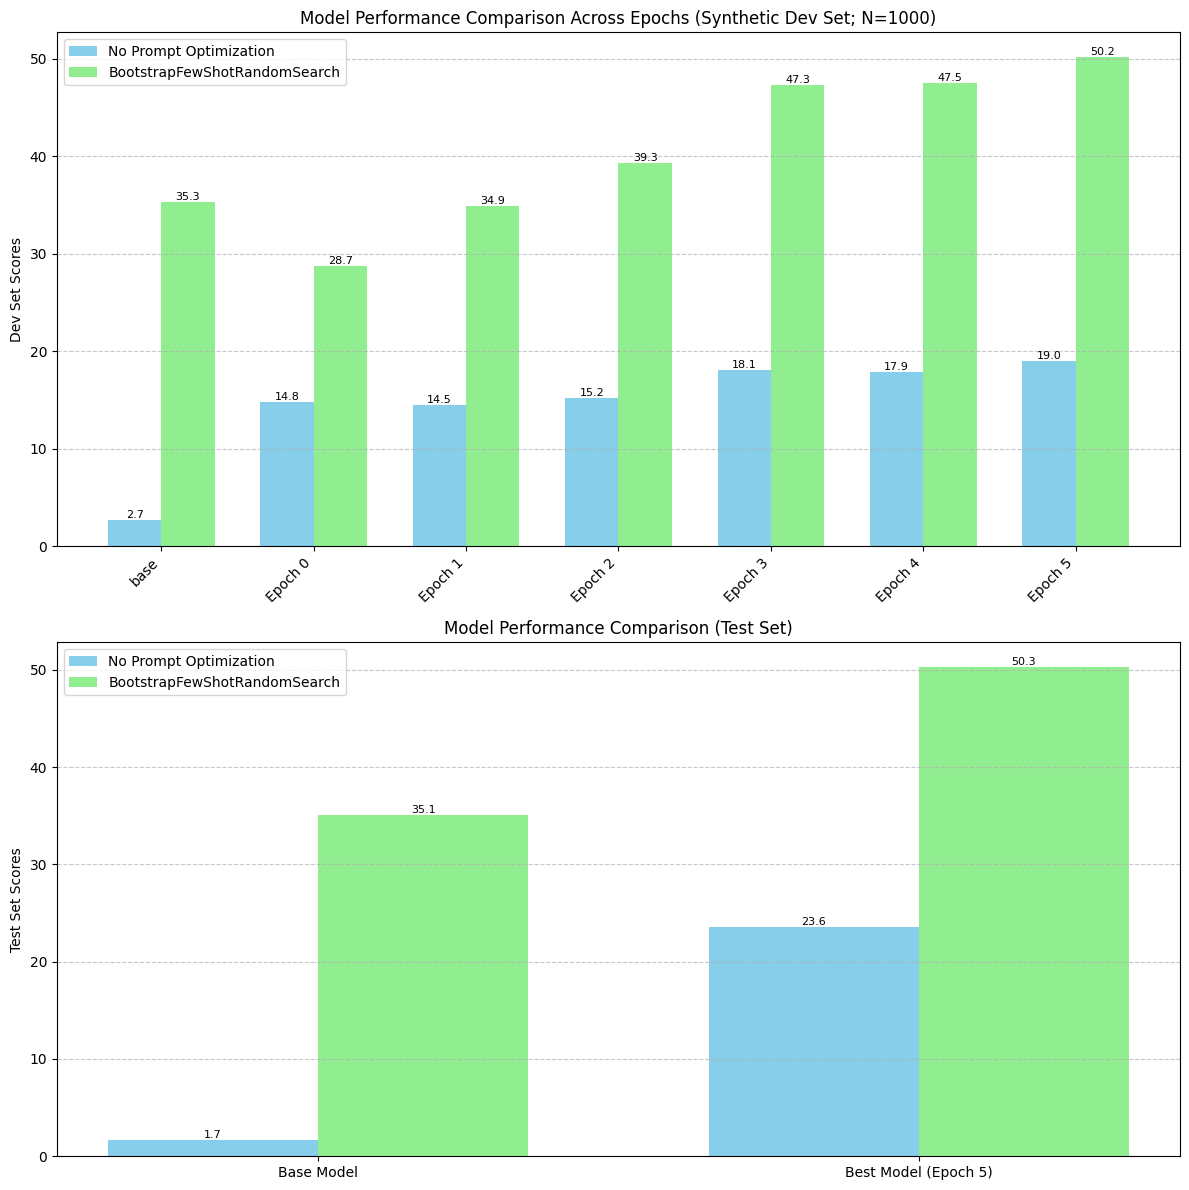

In [32]:
import json
import matplotlib.pyplot as plt
import numpy as np

# Prepare data for plotting
models = []
vanilla_devset = []
bfrs_devset = []
vanilla_testset = []
bfrs_testset = []

for model, results in ft_results.items():
    if model == "base":
        models.append("base")
    else:
        models.append("Epoch " + model.split(':')[1].split('-')[1])  # Extract epoch information
    vanilla_devset.append(results['vanilla']['devset'])
    bfrs_devset.append(results['bfrs']['devset'])
    vanilla_testset.append(results['vanilla'].get('testset', None))
    bfrs_testset.append(results['bfrs'].get('testset', None))

# Sort the data by epoch, keeping "base" at the beginning
sorted_data = sorted(zip(models, vanilla_devset, bfrs_devset, vanilla_testset, bfrs_testset),
                     key=lambda x: (x[0] != "base", x[0]))
models, vanilla_devset, bfrs_devset, vanilla_testset, bfrs_testset = zip(*sorted_data)

for i in range(len(models)):
    print(models[i], "vanilla_devset", vanilla_devset[i], "bfrs_devset", bfrs_devset[i], "vanilla_testset", vanilla_testset[i], "bfrs_testset", bfrs_testset[i])

# Set up the plot
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))

# Adjust bar positions and width
x = np.arange(len(models))
width = 0.35

# Plot bars for Dev Set (top graph)
ax1.bar(x - width/2, vanilla_devset, width, label='No Prompt Optimization', color='skyblue')
ax1.bar(x + width/2, bfrs_devset, width, label='BootstrapFewShotRandomSearch', color='lightgreen')

# Add value labels on top of each bar for Dev Set
for i, v in enumerate(vanilla_devset):
    ax1.text(i - width/2, v, f'{v:.1f}', ha='center', va='bottom', fontsize=8)
for i, v in enumerate(bfrs_devset):
    ax1.text(i + width/2, v, f'{v:.1f}', ha='center', va='bottom', fontsize=8)

# Customize the Dev Set plot
ax1.set_ylabel('Dev Set Scores')
ax1.set_title('Model Performance Comparison Across Epochs (Synthetic Dev Set; N=1000)')
ax1.set_xticks(x)
ax1.set_xticklabels(models, rotation=45, ha='right')
ax1.legend()
ax1.grid(True, axis='y', linestyle='--', alpha=0.7)

# Find the highest devset score and its corresponding model
highest_devset_score = max(bfrs_devset)
highest_score_model = models[bfrs_devset.index(highest_devset_score)]

print(highest_devset_score, highest_score_model, bfrs_devset[models.index(highest_score_model)])

# Prepare data for the bottom graph
# Prepare data for the bottom graph (Test Set)
base_vanilla_testset = vanilla_testset[models.index("base")]
base_bfrs_testset = bfrs_testset[models.index("base")]

best_model_index = bfrs_devset.index(highest_devset_score)
best_vanilla_testset = vanilla_testset[best_model_index]
best_bfrs_testset = bfrs_testset[best_model_index]

print("best_vanilla_testset", best_vanilla_testset, "best_bfrs_testset", best_bfrs_testset)
print("base_vanilla_testset", base_vanilla_testset, "base_bfrs_testset", base_bfrs_testset)

# Plot bars for Test Set (bottom graph)
models_to_plot = ["Base Model", f"Best Model ({highest_score_model})"]
x_test = np.arange(len(models_to_plot))

ax2.bar(x_test - width/2, [base_vanilla_testset, best_vanilla_testset], width, label='No Prompt Optimization', color='skyblue')
ax2.bar(x_test + width/2, [base_bfrs_testset, best_bfrs_testset], width, label='BootstrapFewShotRandomSearch', color='lightgreen')

# Add value labels on top of each bar for Test Set
for i, v in enumerate([base_vanilla_testset, best_vanilla_testset]):
    ax2.text(i - width/2, v, f'{v:.1f}', ha='center', va='bottom', fontsize=8)
for i, v in enumerate([base_bfrs_testset, best_bfrs_testset]):
    ax2.text(i + width/2, v, f'{v:.1f}', ha='center', va='bottom', fontsize=8)

# Customize the Test Set plot
ax2.set_ylabel('Test Set Scores')
ax2.set_title('Model Performance Comparison (Real Test Set; N=1000)')
ax2.set_xticks(x_test)
ax2.set_xticklabels(models_to_plot)
ax2.legend()
ax2.grid(True, axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()


Lastly, lets give the base 8B model a fair chance by prompt optimizing it.

In [ ]:
# Now we can compare all iterations of this pipeline
print(f"Results for HotPotQA fine-tuning LLaMa 8B with a starting trainset")
print(f"    70B model (vanilla program): {llama_70b_base_eval}")
print(f"    70B model (bfrs program): {llama_70b_bfrs_eval}")
print(f"    8B model (vanilla program): {vanilla_8b_base_eval}")
print(f"    8B model (bfrs program): {llama_8b_bfrs_eval}")
print(f"    8B model (finetuned program): {llama_8b_finetuned_eval}")
print(f"    8B model (finetuned bfrs program): {llama_8b_bfrs_finetuned_eval}")
print(f"    8B model (finetuned mipro program): {llama_8b_ft_mipro_eval}")

In [ ]:
raise NotImplementedError("Stop here")

# Serving

This is the second biggest unknown
I imagine it to be easy, but crazier things have happened

I need to keep a reference or link to the LLM forge job inside the LM.finetune method

how do I get the ray llm image!

We'll start by running the rayllm CLI command below to start the workflow to generate the service yaml configuration:
```bash
mkdir /home/ray/default/deploy/services
cd /home/ray/default/deploy/services
rayllm gen-config 
```

<img src="assets/cli.png" width=500 alt="todo! get this inage of what I need to serve">


<b style="background-color: yellow;">&nbsp;🛑 IMPORTANT&nbsp;</b>: Please `Terminate` your service from the Service page to avoid depleting your free trial credits.

In [ ]:
# Clean up
!python src/clear_cell_nums.py
!find . | grep -E ".ipynb_checkpoints" | xargs rm -rf
!find . | grep -E "(__pycache__|\.pyc|\.pyo)" | xargs rm -rf
!rm -rf __pycache__ data .HF_TOKEN deploy/services

# MARK: Ensemble - To Be Removed

In [ ]:
from dspy.teleprompt import Ensemble

# testing ensemble
top_programs = []

for folder, llama in all_llamas.items():
    with dspy.context(lm=llama):
        vanilla_program = IntentClassificationModule()
        bfrs_finetuned_program = bfrs_optimizer.compile(vanilla_program, trainset=optimizer_trainset, valset=optimizer_valset)
        devset_result = evaluate_devset(bfrs_finetuned_program)

        def wrapped_program(*args, **kwargs):
            with dspy.context(lm=llama):
                return bfrs_finetuned_program(*args, **kwargs)
        top_programs.append((wrapped_program, llama, devset_result))

top_3_devset = sorted(top_programs, key=lambda x: x[2], reverse=True)[:3]

teleprompter = Ensemble(reduce_fn=dspy.majority, size=None)
# print(top_3_devset)
programs = [p[0] for p in top_3_devset]
# print(programs)
compiled_program = teleprompter.compile(programs)
# # print(compiled_program)
eval_result = evaluate_devset(compiled_program)
eval_testset = evaluate_testset(compiled_program)
print(f"result for best_ensemble: {eval_result}, {eval_true_labels}, {eval_testset}")
ft_results[folder]["best_ensemble"] = {"devset": eval_result, "true_labels": eval_true_labels, "testset": eval_testset}

# MARK: Prediction no CoT - To Be Removed

In [ ]:
dspy.settings.configure(experimental=True)

from dspy.teleprompt.finetune_teleprompter import bootstrap_data, bootstrap_data_for_round, convert_to_module_level_message_data    

class IntentClassificationPredictModule(dspy.Module):
    def __init__(self):
        self.intent_classifier = dspy.Predict(IntentClassification)
        self.valid_labels = set(["activate_my_card", "cancel_transfer", "cash_withdrawal_charge", "declined_card_payment", "declined_cash_withdrawal", "direct_debit_payment_not_recognised", "extra_charge_on_statement", "pending_card_payment", "pending_top_up", "Refund_not_showing_up", "request_refund", "reverted_card_payment", "transaction_charged_twice", "transfer_fee_charged", "transfer_not_received_by_recipient", "wrong_amount_of_cash_received", "wrong_exchange_rate_for_cash_withdrawal"])

    def forward(self, text):
        prediction = self.intent_classifier(intent=text)
        sanitized_prediction = dspy.Prediction(label=prediction.label.lower().strip().replace(" ", "_"))
        # if sanitized_prediction.label not in self.valid_labels:
        #     for label in self.valid_labels:
        #         if label in sanitized_prediction.label:
        #             sanitized_prediction.label = label
        #             break
        #     # this means that the prediction was not in the valid labels
        #     # Could do edit distance or something more sophisticated here
        #     # but for now just take the first
        #     sanitized_prediction.label = self.valid_labels[0]
        return sanitized_prediction

def convert_examples_to_messages(examples):
    manual_traces = []
    module = IntentClassificationPredictModule()
    for example in examples:
        example["intent"] = example["text"]
        example = example.with_inputs("intent")
        manual_traces.append((module.intent_classifier, example.inputs(), example))

    data = []
    # traces are (pred, inputs, outputs)
    adapter = dspy.ChatAdapter()
    for pred, inputs, outputs in manual_traces:
        messages = adapter.format(pred.signature, [], inputs)
        formatted_completion = adapter.format_completion(pred.signature, outputs)
        messages.append({"role": "assistant", "content": formatted_completion})
        data.append({"messages": messages})

    return data

train_path = f"ft_trainset_data_banking_no_cot_{len(ft_trainset)}.jsonl"
eval_path = f"ft_valset_data_banking_no_cot_{len(devset)}.jsonl"

write_jsonl(train_path, convert_examples_to_messages(ft_trainset))
write_jsonl(eval_path, convert_examples_to_messages(devset))


In [ ]:
from dsp.modules.lm import TrainingMethod


method = TrainingMethod.SFT

kwargs = {
    "hyperparameters": {
        "num_devices": 4,
        "trainer_resources": None,
        "worker_resources": None,
        "generation_config": {
            "prompt_format": {
                "system": "<|start_header_id|>system<|end_header_id|>\n\n{instruction}<|eot_id|>",
                "user": "<|start_header_id|>user<|end_header_id|>\n{instruction}<|eot_id|>",
                "assistant": "<|start_header_id|>assistant<|end_header_id|>\n\n{instruction}<|eot_id|>",
                "trailing_assistant": "<|start_header_id|>assistant<|end_header_id|>\n\n",
                "bos": "<|begin_of_text|>",
                "system_in_user": False,
                "default_system_message": ""
            },
        },
        "learning_rate": 3e-5,
        "num_epochs": 6,
        "train_batch_size_per_device": 32
    },
    "use_lora": True,
    # TODO: I think this needs to be set dynamically
    # "lora_dynamic_folder": "dspy/lora_weights/prodjob_qmulcjw4x8z599m8hkyja8tbmi/meta-llama/Llama-3.2-1B-Instruct"
}

SKIP_FT = False
if not SKIP_FT:
    # TODO: Get job working with LLMForge
    student_llama_1b = dspy.TrainableAnyscale(model="meta-llama/Llama-3.2-1B-Instruct")
    future = student_llama_1b.get_finetune(method, train_path, eval_path, **kwargs)
    checkpoint_names = future.result()

    model_names = checkpoint_names

In [ ]:
import json

if True:
    with open("model_names_predict.json", "r") as f:
        model_names = json.load(f)
else:
    with open("model_names_predict.json", "w") as f:
        json.dump(checkpoint_names, f)
    # model_names = checkpoint_names


In [ ]:
# Command for easy copying: 

llama_1b = dspy.LM(model="openai/meta-llama/Llama-3.2-1B-Instruct", **LOCAL_API_PARAMETERS, **MODEL_PARAMETERS)
finetuned_llamas_1b = {f: dspy.LM(model="openai/" + f, **LOCAL_API_PARAMETERS, **MODEL_PARAMETERS) for f in model_names}
all_llamas = {**finetuned_llamas_1b, "base": llama_1b}

In [ ]:
print([x.model for x in all_llamas.values()])


In [ ]:
# collected_data_filtered[0]
def collected_data_to_example(data):
    return dspy.Example(text=data["example"]["text"], label=data["prediction"]["label"]).with_inputs("text")

collected_data_examples = [collected_data_to_example(x) for x in collected_data_filtered]
# collected_data_examples[0]

devset_synthetic = collected_data_examples[:DEV_SIZE]
ft_optimizer_devset = collected_data_examples[DEV_SIZE:DEV_SIZE+OPTIMIZER_NUM_VAL]
ft_optimizer_trainset = collected_data_examples[DEV_SIZE+OPTIMIZER_NUM_VAL:]

evaluate_devset = Evaluate(devset=devset_synthetic, metric=metric, num_threads=NUM_THREADS, display_progress=True, max_errors=10000)

print(len(devset_synthetic), len(ft_optimizer_trainset), len(ft_optimizer_devset))
print(devset_synthetic[0])

In [ ]:
COMPILE_PROGRAM = True

dspy.settings.configure(experimental=True, lm=None)

ft_results = {}
for folder, llama in all_llamas.items():
    ft_results[folder] = {}
    vanilla_program = IntentClassificationModule()
    with dspy.context(lm=llama):
        devset_result = evaluate_devset(vanilla_program)
        ft_results[folder]["vanilla"] = {"devset": devset_result, "testset": None}

        if COMPILE_PROGRAM:
            bfrs_finetuned_program = bfrs_optimizer.compile(vanilla_program, trainset=ft_optimizer_trainset, valset=ft_optimizer_devset)
            bfrs_finetuned_program.save(f"simpleintent_predict_1b_32_ft_bfrs_{MAX_BOOTSTRAPPED_DEMOS}_{MAX_LABELED_DEMOS}_{NUM_CANDIDATE_PROGRAMS}_{folder.split('/')[-1]}.json")
        else:
            bfrs_finetuned_program = IntentClassificationModule()
            bfrs_finetuned_program.load(f"simpleintent_predict_1b_32_ft_bfrs_{MAX_BOOTSTRAPPED_DEMOS}_{MAX_LABELED_DEMOS}_{NUM_CANDIDATE_PROGRAMS}_{folder.split('/')[-1]}.json")
        
        llama_8b_bfrs_finetuned_eval = evaluate_devset(bfrs_finetuned_program)
        ft_results[folder]["bfrs"] = {"devset": llama_8b_bfrs_finetuned_eval, "true_labels": None, "testset": None}
        print(f"result for {folder}: {llama_8b_bfrs_finetuned_eval}, None, None")

In [ ]:
original_ft_results = json.load(open("ft_results.json", "r"))
combined_ft_results = {"cot": original_ft_results, "no_cot": ft_results}

combined_ft_results

In [ ]:
import json
import matplotlib.pyplot as plt
import numpy as np

# Prepare data for plotting
models = []
vanilla_devset = []
bfrs_devset = []
vanilla_testset = []
bfrs_testset = []

for model, results in ft_results.items():
    if model == "base":
        models.append("base")
    else:
        models.append("Epoch " + model.split(':')[1].split('-')[1])  # Extract epoch information
    vanilla_devset.append(results['vanilla']['devset'])
    bfrs_devset.append(results['bfrs']['devset'])
    vanilla_testset.append(results['vanilla']['testset'])
    bfrs_testset.append(results['bfrs']['testset'])

# Sort the data by epoch, keeping "base" at the beginning
sorted_data = sorted(zip(models, vanilla_devset, bfrs_devset, vanilla_testset, bfrs_testset),
                     key=lambda x: (x[0] != "base", x[0]))
models, vanilla_devset, bfrs_devset, vanilla_testset, bfrs_testset = zip(*sorted_data)

for i in range(len(models)):
    print(models[i], "vanilla_devset", vanilla_devset[i], "bfrs_devset", bfrs_devset[i], "vanilla_testset", vanilla_testset[i], "bfrs_testset", bfrs_testset[i])

# Set up the plot
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))

# Adjust bar positions and width
x = np.arange(len(models))
width = 0.35

# Plot bars for Dev Set (top graph)
ax1.bar(x - width/2, vanilla_devset, width, label='Vanilla Dev', color='skyblue')
ax1.bar(x + width/2, bfrs_devset, width, label='BFRS Dev', color='lightgreen')

# Add value labels on top of each bar for Dev Set
for i, v in enumerate(vanilla_devset):
    ax1.text(i - width/2, v, f'{v:.1f}', ha='center', va='bottom', fontsize=8)
for i, v in enumerate(bfrs_devset):
    ax1.text(i + width/2, v, f'{v:.1f}', ha='center', va='bottom', fontsize=8)

# Customize the Dev Set plot
ax1.set_ylabel('Dev Set Scores')
ax1.set_title('Model Performance Comparison Across Epochs (Dev Set)')
ax1.set_xticks(x)
ax1.set_xticklabels(models, rotation=45, ha='right')
ax1.legend()
ax1.grid(True, axis='y', linestyle='--', alpha=0.7)

# Find the highest devset score and its corresponding model
highest_devset_score = max(bfrs_devset)
highest_score_model = models[bfrs_devset.index(highest_devset_score)]

print(highest_devset_score, highest_score_model, bfrs_devset[models.index(highest_score_model)])

# Prepare data for the bottom graph
# Prepare data for the bottom graph (Test Set)
base_vanilla_testset = vanilla_testset[models.index("base")]
base_bfrs_testset = bfrs_testset[models.index("base")]

best_model_index = bfrs_devset.index(highest_devset_score)
best_vanilla_testset = vanilla_testset[best_model_index]
best_bfrs_testset = bfrs_testset[best_model_index]

print("best_vanilla_testset", best_vanilla_testset, "best_bfrs_testset", best_bfrs_testset)
print("base_vanilla_testset", base_vanilla_testset, "base_bfrs_testset", base_bfrs_testset)

# Plot bars for Test Set (bottom graph)
models_to_plot = ["Base Model", f"Best Model ({highest_score_model})"]
x_test = np.arange(len(models_to_plot))

ax2.bar(x_test - width/2, [base_vanilla_testset, best_vanilla_testset], width, label='Vanilla Test', color='coral')
ax2.bar(x_test + width/2, [base_bfrs_testset, best_bfrs_testset], width, label='BFRS Test', color='lightseagreen')

# Add value labels on top of each bar for Test Set
for i, v in enumerate([base_vanilla_testset, best_vanilla_testset]):
    ax2.text(i - width/2, v, f'{v:.1f}', ha='center', va='bottom', fontsize=8)
for i, v in enumerate([base_bfrs_testset, best_bfrs_testset]):
    ax2.text(i + width/2, v, f'{v:.1f}', ha='center', va='bottom', fontsize=8)

# Customize the Test Set plot
ax2.set_ylabel('Test Set Scores')
ax2.set_title('Model Performance Comparison (Test Set)')
ax2.set_xticks(x_test)
ax2.set_xticklabels(models_to_plot)
ax2.legend()
ax2.grid(True, axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()


In [ ]:
# # {'cot': {'meta-llama/Llama-3.2-1B-Instruct:epochs-2-total-trained-steps-69': {'vanilla': {'devset': 26.2,
#     'testset': 28.4},
#    'bfrs': {'devset': 32.4, 'true_labels': None, 'testset': 32.4}},
#   'meta-llama/Llama-3.2-1B-Instruct:epochs-5-total-trained-steps-138': {'vanilla': {'devset': 28.8,
#     'testset': 32.3},
#    'bfrs': {'devset': 42.0, 'true_labels': None, 'testset': 43.1}},
#   'meta-llama/Llama-3.2-1B-Instruct:epochs-4-total-trained-steps-115': {'vanilla': {'devset': 28.2,
#     'testset': 32.5},
#    'bfrs': {'devset': 37.2, 'true_labels': None, 'testset': 38.6}},
#   'meta-llama/Llama-3.2-1B-Instruct:epochs-3-total-trained-steps-92': {'vanilla': {'devset': 30.2,
#     'testset': 34.1},
#    'bfrs': {'devset': 38.4, 'true_labels': None, 'testset': 37.5}},
#   'meta-llama/Llama-3.2-1B-Instruct:epochs-1-total-trained-steps-46': {'vanilla': {'devset': 15.6,
#     'testset': 14.6},
#    'bfrs': {'devset': 27.6, 'true_labels': None, 'testset': 29.0}},
#   'meta-llama/Llama-3.2-1B-Instruct:epochs-0-total-trained-steps-23': {'vanilla': {'devset': 22.6,
#     'testset': 20.4},
#    'bfrs': {'devset': 29.0, 'true_labels': None, 'testset': 32.1}},
#   'base': {'vanilla': {'devset': 1.4, 'testset': 1.9},
#    'bfrs': {'devset': 27.8, 'true_labels': None, 'testset': 28.9}}},
#  'no_cot': {'meta-llama/Llama-3.2-1B-Instruct:epochs-0-total-trained-steps-29': {'vanilla': {'devset': 21.4,
#     'testset': 22.2},
#    'bfrs': {'devset': 34.8, 'true_labels': None, 'testset': 37.9}},
#   'meta-llama/Llama-3.2-1B-Instruct:epochs-5-total-trained-steps-174': {'vanilla': {'devset': 43.8,
#     'testset': 45.1},
#    'bfrs': {'devset': 43.8, 'true_labels': None, 'testset': 45.1}},
#   'meta-llama/Llama-3.2-1B-Instruct:epochs-1-total-trained-steps-58': {'vanilla': {'devset': 14.6,
#     'testset': 16.3},
#    'bfrs': {'devset': 34.4, 'true_labels': None, 'testset': 36.2}},
#   'meta-llama/Llama-3.2-1B-Instruct:epochs-2-total-trained-steps-87': {'vanilla': {'devset': 37.8,
#     'testset': 41.8},
#    'bfrs': {'devset': 37.8, 'true_labels': None, 'testset': 41.8}},
#   'meta-llama/Llama-3.2-1B-Instruct:epochs-4-total-trained-steps-145': {'vanilla': {'devset': 45.0,
#     'testset': 46.3},
#    'bfrs': {'devset': 45.0, 'true_labels': None, 'testset': 46.3}},
#   'meta-llama/Llama-3.2-1B-Instruct:epochs-3-total-trained-steps-116': {'vanilla': {'devset': 45.2,
#     'testset': 45.9},
#    'bfrs': {'devset': 45.2, 'true_labels': None, 'testset': 45.9}},
#   'base': {'vanilla': {'devset': 9.4, 'testset': 8.6},
#    'bfrs': {'devset': 36.4, 'true_labels': None, 'testset': 38.8}}}}



import matplotlib.pyplot as plt
import numpy as np

def extract_data(results, key):
    return {
        model: {
            'vanilla': data['vanilla'][key],
            'bfrs': data['bfrs'][key]
        }
        for model, data in results.items()
    }

cot_devset = extract_data(combined_ft_results['cot'], 'devset')
no_cot_devset = extract_data(combined_ft_results['no_cot'], 'devset')
print(no_cot_devset)

# Prepare data for plotting
models = list(cot_devset.keys())
x = np.arange(len(models))
width = 0.2

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 20))

# Top graph
ax1.bar(x - 1.5*width, [cot_devset[m]['vanilla'] for m in models], width, label='CoT Vanilla')
ax1.bar(x - 0.5*width, [cot_devset[m]['bfrs'] for m in models], width, label='CoT BFRS')
ax1.bar(x + 0.5*width, [no_cot_devset[m]['vanilla'] for m in models], width, label='No CoT Vanilla')
ax1.bar(x + 1.5*width, [no_cot_devset[m]['bfrs'] for m in models], width, label='No CoT BFRS')

ax1.set_ylabel('Devset Score')
ax1.set_title('CoT vs No CoT: Vanilla and BFRS on Devset')
ax1.set_xticks(x)
ax1.set_xticklabels(models, rotation=45, ha='right')
ax1.legend()

# Find best models
best_cot = max(cot_devset.items(), key=lambda x: x[1]['bfrs'])[0]
best_no_cot = max(no_cot_devset.items(), key=lambda x: x[1]['bfrs'])[0]

# Bottom graph
models = ['Best CoT', 'Best No CoT']
x = np.arange(len(models))

cot_data = ft_results['cot'][best_cot]
no_cot_data = ft_results['no_cot'][best_no_cot]

ax2.bar(x - 1.5*width, [cot_data['vanilla']['devset'], no_cot_data['vanilla']['devset']], width, label='Vanilla Devset')
ax2.bar(x - 0.5*width, [cot_data['bfrs']['devset'], no_cot_data['bfrs']['devset']], width, label='BFRS Devset')
ax2.bar(x + 0.5*width, [cot_data['vanilla']['testset'], no_cot_data['vanilla']['testset']], width, label='Vanilla Testset')
ax2.bar(x + 1.5*width, [cot_data['bfrs']['testset'], no_cot_data['bfrs']['testset']], width, label='BFRS Testset')

ax2.set_ylabel('Score')
ax2.set_title('Best CoT vs Best No CoT: Devset and Testset Results')
ax2.set_xticks(x)
ax2.set_xticklabels(models)
ax2.legend()

plt.tight_layout()
plt.show()


In [ ]:
# MARK: Mipro
# from dspy.teleprompt import MIPROv2

# eval_kwargs = dict(display_progress=True, display_table=0, num_threads=NUM_THREADS)
# teleprompter = MIPROv2(prompt_model=llama_70b, task_model=llama_70b, metric=metric, num_candidates=10, init_temperature=0.9, verbose=True)

# COMPILE_PROGRAM = True
# if COMPILE_PROGRAM:
#     with dspy.context(lm=llama_70b):
#         compiled_program = teleprompter.compile(vanilla_program, trainset=optimizer_trainset, valset=optimizer_valset, num_batches=30, max_bootstrapped_demos=MAX_BOOTSTRAPPED_DEMOS,max_labeled_demos=MAX_LABELED_DEMOS, eval_kwargs=eval_kwargs, requires_permission_to_run=False)
#         compiled_program.save(f"t2sql_70b_31_MIPROv2_{MAX_BOOTSTRAPPED_DEMOS}_{MAX_LABELED_DEMOS}.json")
# else:
#     compiled_program = TextToSQLModule()
#     compiled_program.load(f"t2sql_70b_31_MIPROv2_{MAX_BOOTSTRAPPED_DEMOS}_{MAX_LABELED_DEMOS}.json")

# with dspy.context(lm=llama_70b):
#     llama_70b_mipro_eval = evaluate_devset(compiled_program)